Step 1: Setup and Environment Configuration
python

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler
import pickle
import time
from google.colab import drive
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive to save models
drive.mount('/content/drive')

# Create directory for storing models
import os
models_dir = '/content/drive/MyDrive/dropout_prediction_models'
os.makedirs(models_dir, exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

# Set display options
pd.set_option('display.max_columns', None)


Mounted at /content/drive


Step 2: Dempster-Shafer Evidence Theory Implementation

In [ ]:
class DempsterShaferCombination:
    """
    Implementation of the Dempster-Shafer theory for evidence combination.

    This class combines evidence from multiple sources (anomaly detection,
    classification, and expert rules) to provide a belief interval for
    student dropout prediction.
    """

    def __init__(self, classes=["non-dropout", "dropout"]):
        self.classes = classes
        self.frame = [
            set(),
            {classes[0]},
            {classes[1]},
            set(classes)
        ]

    def _convert_proba_to_mass(self, proba, uncertainty=0.4):
        """
        Convert probability to mass function.
        """
        proba = min(max(proba, 0.0001), 0.9999)  # Clamp to avoid zeros
        mass = {}
        mass[frozenset()] = 0
        mass[frozenset({self.classes[0]})] = (1 - proba) * (1 - uncertainty)
        mass[frozenset({self.classes[1]})] = proba * (1 - uncertainty)
        mass[frozenset(self.classes)] = uncertainty
        return mass

    def _combine_masses(self, mass1, mass2):
        """
        Combine two mass functions using Dempster's rule.
        """
        combined_mass = {}
        normalization = 0

        for key1 in mass1:
            for key2 in mass2:
                intersection = frozenset(set(key1).intersection(set(key2)))
                mass_product = mass1[key1] * mass2[key2]
                if not intersection:
                    normalization += mass_product
                else:
                    combined_mass[intersection] = combined_mass.get(intersection, 0) + mass_product

        if normalization < 1:
            for key in combined_mass:
                combined_mass[key] /= (1 - normalization)

        for subset in [frozenset(), frozenset({self.classes[0]}),
                       frozenset({self.classes[1]}), frozenset(self.classes)]:
            if subset not in combined_mass:
                combined_mass[subset] = 0

        return combined_mass

    def combine_evidence(self, anomaly_score, classification_proba, expert_score=None):
    # Convert to mass with revised uncertainty (no weighted_proba here)
      mass_anomaly = self._convert_proba_to_mass(anomaly_score, uncertainty=0.25)
      mass_classifier = self._convert_proba_to_mass(classification_proba, uncertainty=0.15)

      combined_mass = self._combine_masses(mass_anomaly, mass_classifier)

      if expert_score is not None:
          mass_expert = self._convert_proba_to_mass(expert_score, uncertainty=0.2)
          combined_mass = self._combine_masses(combined_mass, mass_expert)

      dropout_class = frozenset({self.classes[1]})
      belief = combined_mass[dropout_class]
      plausibility = belief + combined_mass[frozenset(self.classes)]
      uncertainty = plausibility - belief

      return {
        "belief": belief,
        "plausibility": plausibility,
        "uncertainty": uncertainty,
        "combined_mass": combined_mass
    }


Step 3: Data Generation for Student Dropout Prediction

In [ ]:
def generate_student_data(n_samples=1000, dropout_rate=0.3):
    """
    Generate synthetic student data with meaningful features for dropout prediction.

    Parameters:
    -----------
    n_samples: int
        Number of student records to generate
    dropout_rate: float
        Approximate proportion of students who drop out

    Returns:
    --------
    student_data: pandas DataFrame
        Generated student dataset
    """
    print(f"Generating {n_samples} student records...")

    # Student ID
    student_ids = [f'S{i:04d}' for i in range(1, n_samples + 1)]

    # Academic features
    gpa = np.clip(np.random.normal(3.0, 0.7, n_samples), 0, 4)
    attendance = np.clip(np.random.normal(85, 10, n_samples), 50, 100)
    semester = np.random.randint(1, 9, n_samples)
    prev_gpa = np.clip(gpa + np.random.normal(0, 0.3, n_samples), 0, 4)
    failed_courses = np.random.poisson(1, n_samples)

    # Behavioral features
    feedback_engagement = np.clip(np.random.normal(70, 20, n_samples), 0, 100)
    late_assignments = np.clip(np.random.normal(20, 15, n_samples), 0, 100)
    forum_participation = np.random.poisson(3, n_samples)
    meeting_attendance = np.clip(np.random.normal(80, 15, n_samples), 0, 100)
    study_group = np.random.choice([0, 1, 2, 3], n_samples, p=[0.4, 0.3, 0.2, 0.1])

    # Online behavior features (important for anomaly detection)
    days_active = np.clip(np.random.normal(5, 1, n_samples), 0, 7)  # days active per week
    clicks_per_week = np.clip(np.random.negative_binomial(10, 0.5, n_samples), 0, 500)
    assessments_submitted = np.random.poisson(5, n_samples)
    previous_attempts = np.random.poisson(0.7, n_samples)
    studied_credits = np.random.randint(10, 40, n_samples)

    # Generate dropout labels based on risk factors
    # Higher dropout risk if GPA < 2.5, attendance < 70, failed courses > 2, low feedback engagement
    risk_score = (
        (gpa < 2.5).astype(float) * 0.4 +
        (attendance < 70).astype(float) * 0.3 +
        (failed_courses > 2).astype(float) * 0.2 +
        (feedback_engagement < 50).astype(float) * 0.1
    )

    # Add some randomness to make it more realistic
    risk_score += np.random.normal(0, 0.1, n_samples)

    # Set dropout label based on risk score threshold
    dropout = (risk_score > 0.5).astype(int)

    # Adjust to meet target dropout rate
    current_rate = dropout.mean()
    if current_rate != dropout_rate:
        # Number of samples to change
        n_to_change = int(abs(current_rate - dropout_rate) * n_samples)

        if current_rate < dropout_rate:
            # Need more dropouts
            indices = np.where(dropout == 0)[0]
            change_indices = np.random.choice(indices, n_to_change, replace=False)
            dropout[change_indices] = 1
        else:
            # Need fewer dropouts
            indices = np.where(dropout == 1)[0]
            change_indices = np.random.choice(indices, n_to_change, replace=False)
            dropout[change_indices] = 0

    # Create DataFrame
    student_data = pd.DataFrame({
        'student_id': student_ids,
        'gpa': gpa,
        'attendance': attendance,
        'semester': semester,
        'prev_gpa': prev_gpa,
        'failed_courses': failed_courses,
        'feedback_engagement': feedback_engagement,
        'late_assignments': late_assignments,
        'forum_participation': forum_participation,
        'meeting_attendance': meeting_attendance,
        'study_group': study_group,
        'days_active': days_active,
        'clicks_per_week': clicks_per_week,
        'assessments_submitted': assessments_submitted,
        'previous_attempts': previous_attempts,
        'studied_credits': studied_credits,
        'dropout': dropout
    })

    print(f"Generated dataset with {student_data['dropout'].sum()} dropouts ({student_data['dropout'].mean()*100:.1f}%)")

    return student_data

# Generate student data
student_data = generate_student_data(n_samples=1000, dropout_rate=0.3)
student_data.head()


Generating 1000 student records...
Generated dataset with 299 dropouts (29.9%)


,student_id,gpa,attendance,semester,prev_gpa,failed_courses,feedback_engagement,late_assignments,forum_participation,meeting_attendance,study_group,days_active,clicks_per_week,assessments_submitted,previous_attempts,studied_credits,dropout
0,S0001,3.347700,98.993554,6,2.898741,0,44.818687,1.450055,5,84.171882,3,6.911595,15,6,0,12,0
1,S0002,2.903215,94.246337,7,2.708208,0,85.740331,13.599404,1,55.611620,1,5.666090,12,5,0,27,1
2,S0003,3.453382,85.596304,6,3.428351,1,90.475526,22.014922,1,79.532967,2,4.967114,8,9,1,26,1
3,S0004,4.000000,78.530632,3,3.565106,0,61.931246,10.275495,5,85.012984,1,4.543926,18,9,0,20,1
4,S0005,2.836093,91.982233,3,2.559535,3,79.778545,30.545977,3,59.371108,2,6.077162,10,7,1,14,0


Step 4: Data Exploration and Visualization

📊 Dataset Overview:
- Total Records: 1000
- Total Features (excluding target): 16
- Dropout Rate: 29.9%

🔍 Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
gpa,1000.0,2.987250,0.634053,0.731113,2.546687,3.017710,3.453561,4.000000
attendance,1000.0,85.372510,9.342268,55.596114,78.937583,85.630771,92.288822,100.000000
semester,1000.0,4.426000,2.300830,1.000000,2.000000,4.000000,6.000000,8.000000
prev_gpa,1000.0,2.973420,0.684453,0.533762,2.494632,2.990120,3.535536,4.000000
failed_courses,1000.0,0.979000,0.959938,0.000000,0.000000,1.000000,2.000000,5.000000
feedback_engagement,1000.0,67.991307,19.628997,0.000000,55.278473,68.993677,82.401944,100.000000
late_assignments,1000.0,20.026754,14.060819,0.000000,8.769970,19.398537,29.864520,68.602087
forum_participation,1000.0,2.982000,1.743191,0.000000,2.000000,3.000000,4.000000,10.000000
meeting_attendance,1000.0,78.805716,13.691511,28.186177,69.207219,79.562342,89.096224,100.000000
study_group,1000.0,1.003000,0.976701,0.000000,0.000000,1.000000,2.000000,3.000000


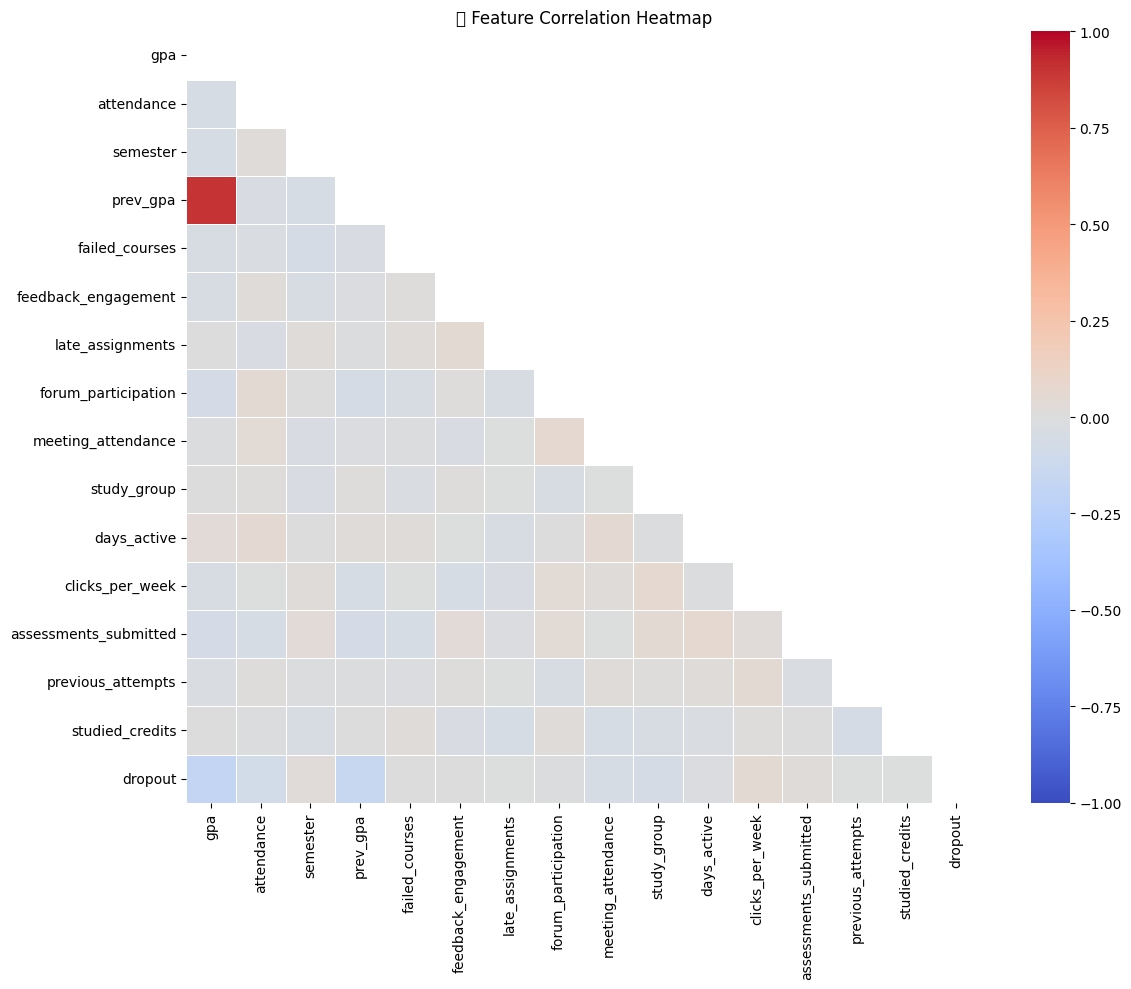

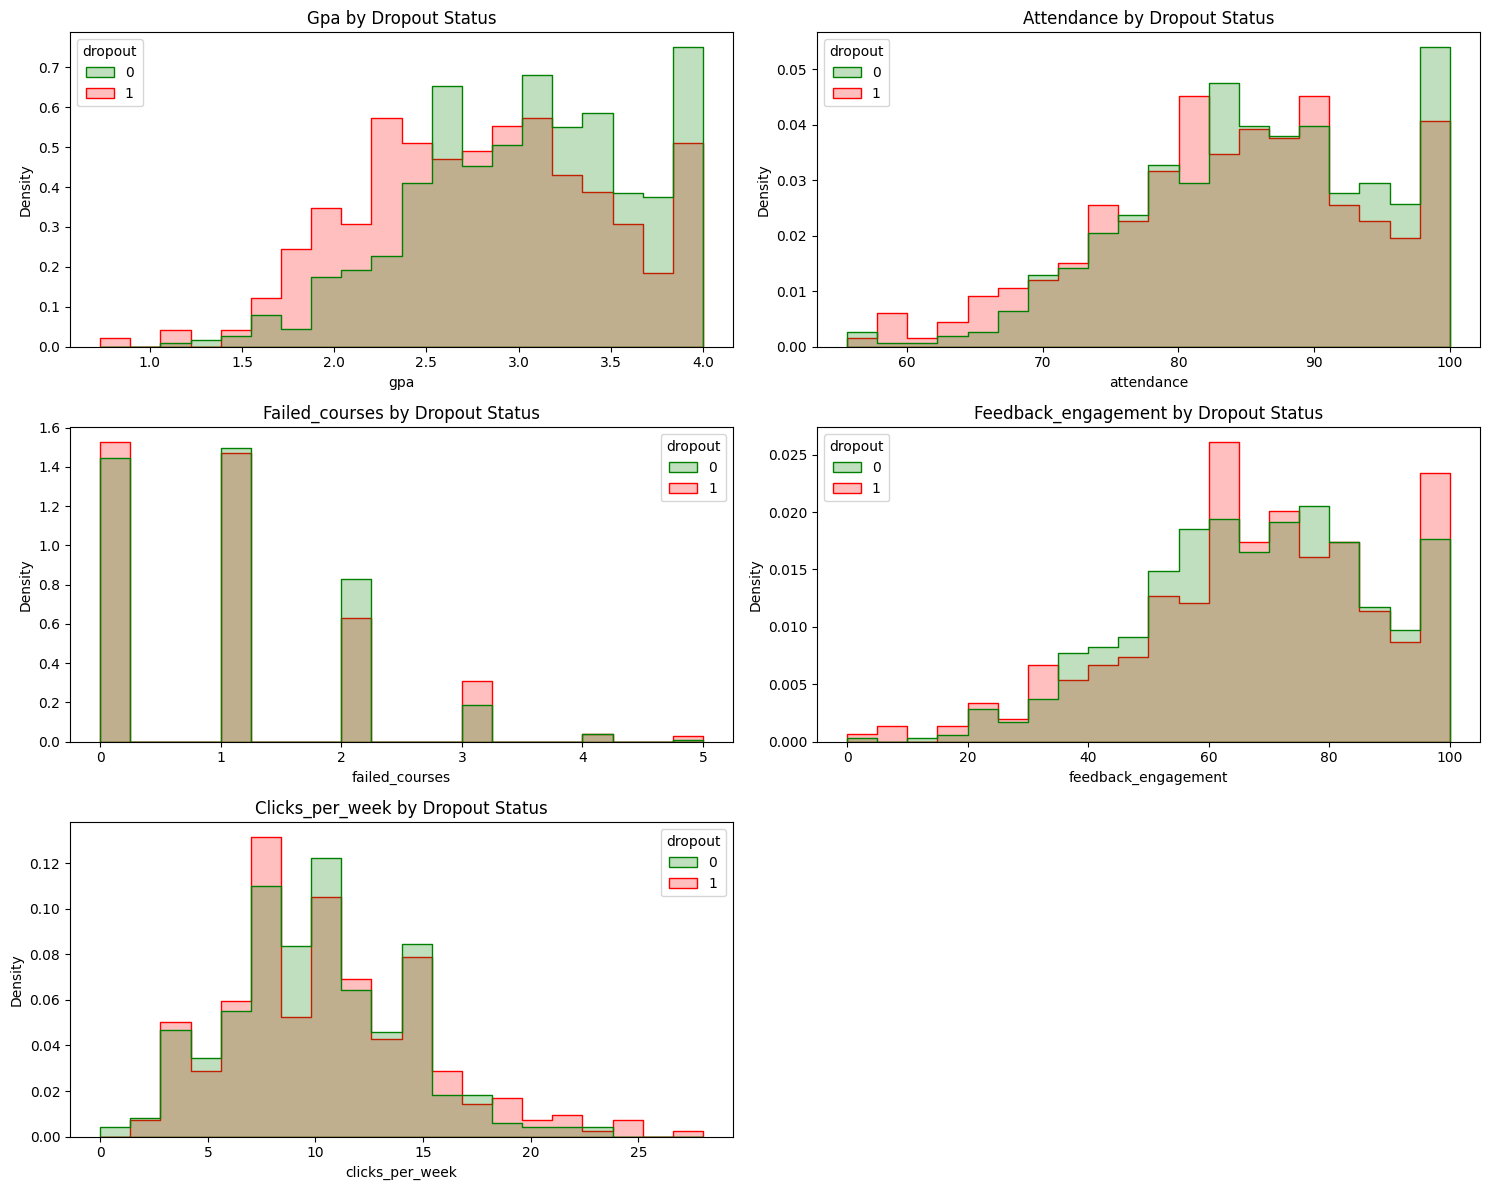

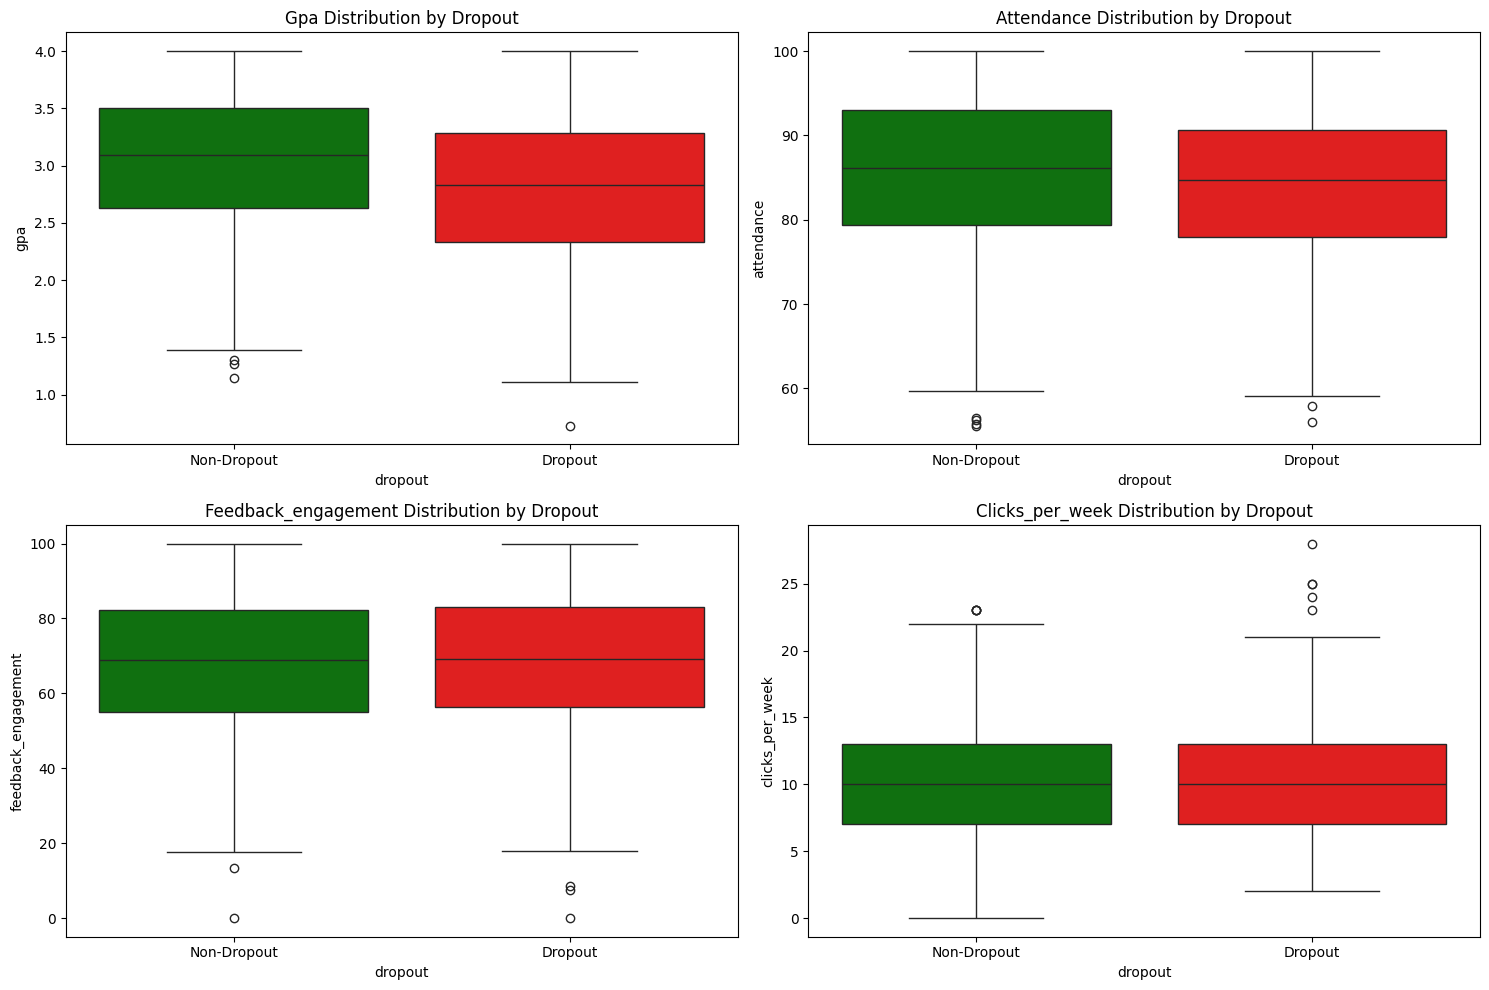

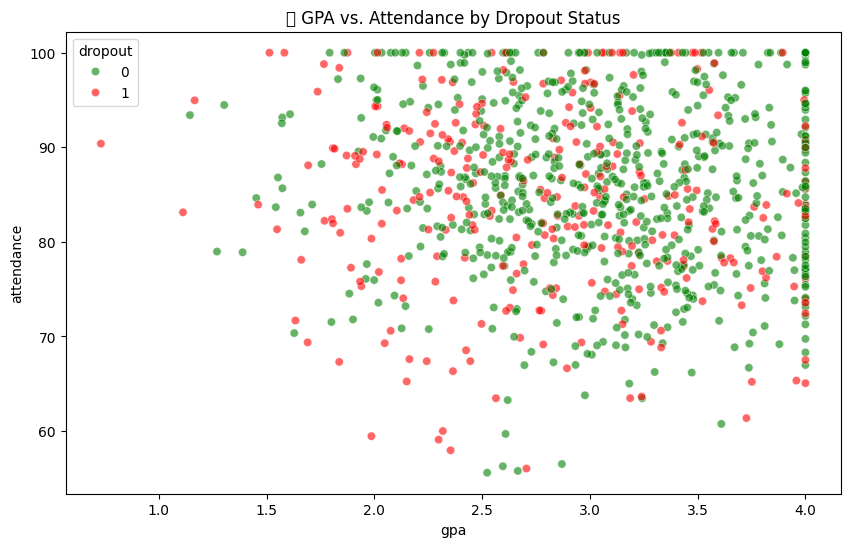

In [ ]:
def explore_student_data(df):
    """
    Explore and visualize student data

    Parameters:
    -----------
    df: pandas DataFrame
        Student data to explore
    """
    print("📊 Dataset Overview:")
    print(f"- Total Records: {len(df)}")
    print(f"- Total Features (excluding target): {df.shape[1] - 1}")
    print(f"- Dropout Rate: {df['dropout'].mean() * 100:.1f}%")

    # Display statistics
    print("\n🔍 Descriptive Statistics:")
    display(df.describe().T)

    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    corr_matrix = df.drop(columns=['student_id']).corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm',
                vmin=-1, vmax=1, center=0, linewidths=0.5)
    plt.title('🔗 Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    # Feature distributions by dropout
    features_to_plot = ['gpa', 'attendance', 'failed_courses',
                        'feedback_engagement', 'clicks_per_week']

    plt.figure(figsize=(15, 12))
    for i, feature in enumerate(features_to_plot):
        plt.subplot(3, 2, i + 1)
        sns.histplot(data=df, x=feature, hue='dropout', bins=20,
                     element='step', stat='density', common_norm=False,
                     palette=['green', 'red'], hue_order=[0, 1])
        plt.title(f'{feature.capitalize()} by Dropout Status')

    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(15, 10))
    boxplot_features = ['gpa', 'attendance', 'feedback_engagement', 'clicks_per_week']
    for i, feature in enumerate(boxplot_features):
        plt.subplot(2, 2, i+1)
        sns.boxplot(data=df, x='dropout', y=feature, palette=['green', 'red'])
        plt.title(f'{feature.capitalize()} Distribution by Dropout')
        plt.xticks([0, 1], ['Non-Dropout', 'Dropout'])

    plt.tight_layout()
    plt.show()

    # Scatter plot: GPA vs. Attendance
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='gpa', y='attendance', hue='dropout',
                    palette=['green', 'red'], alpha=0.6, hue_order=[0, 1])
    plt.title('📉 GPA vs. Attendance by Dropout Status')
    plt.show()
explore_student_data(student_data)

In [ ]:
#download dataset
student_data.to_csv("student_dropout_dataset.csv", index=False)
print("📁 Dataset saved as 'student_dropout_dataset.csv'")
files.download("student_dropout_dataset.csv")

📁 Dataset saved as 'student_dropout_dataset.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Step 5: Data Preprocessing and Split

In [ ]:
def preprocess_data(df):
    """
    Preprocess student data for modeling

    Parameters:
    -----------
    df: pandas DataFrame
        Raw student data

    Returns:
    --------
    X: pandas DataFrame
        Processed feature matrix
    y: pandas Series
        Target variable (dropout)
    """
    print("Preprocessing data...")

    # Make a copy to avoid modifying the original
    processed_df = df.copy()

    # Remove student ID as it's not a predictive feature
    if 'student_id' in processed_df.columns:
        processed_df = processed_df.drop(columns=['student_id'])

    # Split features and target
    X = processed_df.drop(columns=['dropout'])
    y = processed_df['dropout']

    print(f"Processed data shape: {X.shape}")

    return X, y

# Split data for hold-out validation
def split_data(X, y, test_size=0.2, val_size=0.15):
    """
    Split data into train, validation, and test sets

    Parameters:
    -----------
    X: pandas DataFrame
        Feature matrix
    y: pandas Series
        Target variable
    test_size: float
        Proportion of data to use for testing
    val_size: float
        Proportion of data to use for validation

    Returns:
    --------
    X_train, X_val, X_test: pandas DataFrames
        Feature matrices for train, validation, and test sets
    y_train, y_val, y_test: pandas Series
        Target variables for train, validation, and test sets
    """
    print("Splitting data into train, validation, and test sets...")

    # First split out the test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    # Then split the remaining data into train and validation sets
    # Adjust validation size to account for the test split
    adjusted_val_size = val_size / (1 - test_size)

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=adjusted_val_size,
        random_state=42, stratify=y_temp
    )

    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Preprocess and split the data
X, y = preprocess_data(student_data)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)


Preprocessing data...
Processed data shape: (1000, 15)
Splitting data into train, validation, and test sets...
Train set: 650 samples
Validation set: 150 samples
Test set: 200 samples


Step 6: Anomaly Detection with Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np

def train_anomaly_detector(X_train, contamination=0.1):
    """
    Train an Isolation Forest model for anomaly detection.

    Parameters:
    -----------
    X_train : pandas DataFrame
        Training data.
    contamination : float
        Proportion of expected anomalies.

    Returns:
    --------
    iso_forest : IsolationForest
        Trained model.
    anomaly_features : list
        Features used for anomaly detection.
    """
    print("Training Isolation Forest for anomaly detection...")

    # Features related to behavioral activity
    anomaly_features = ['clicks_per_week', 'days_active', 'previous_attempts',
                        'studied_credits', 'assessments_submitted']

    # Only use features that are present in the dataset
    available_features = [f for f in anomaly_features if f in X_train.columns]
    missing = set(anomaly_features) - set(available_features)
    if missing:
        print(f"⚠️ Warning: Missing anomaly features: {missing}")
    if not available_features:
        raise ValueError("No valid features found for anomaly detection.")

    # Train the Isolation Forest
    iso_forest = IsolationForest(
        n_estimators=100,
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    )
    iso_forest.fit(X_train[available_features])

    print("✅ Anomaly detection model trained successfully.")
    return iso_forest, available_features


def detect_anomalies(model, X, anomaly_features):
    """
    Predict anomalies using the trained model.

    Parameters:
    -----------
    model : IsolationForest
        Trained anomaly detection model.
    X : pandas DataFrame
        Data to evaluate.
    anomaly_features : list
        List of features used for detection.

    Returns:
    --------
    anomaly_scores : numpy array
        Normalized anomaly scores.
    is_anomaly : numpy array
        Binary labels: 1 = anomaly, 0 = normal.
    """
    print("Detecting anomalies...")

    # Compute anomaly scores
    raw_scores = model.decision_function(X[anomaly_features])
    anomaly_scores = -raw_scores  # higher = more anomalous

    # Normalize scores to [0, 1]
    if anomaly_scores.max() != anomaly_scores.min():
        anomaly_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())
    else:
        anomaly_scores = np.zeros_like(anomaly_scores)

    # Get predictions: -1 = anomaly, 1 = normal
    raw_preds = model.predict(X[anomaly_features])
    is_anomaly = np.where(raw_preds == -1, 1, 0)

    print(f"⚠️ {is_anomaly.sum()} anomalies detected ({is_anomaly.mean() * 100:.1f}%)")

    return anomaly_scores, is_anomaly


In [ ]:
# Step 1: Train the detector
iso_forest, anomaly_features = train_anomaly_detector(X_train)

# Step 2: Detect on each set
train_anomaly_scores, train_is_anomaly = detect_anomalies(iso_forest, X_train, anomaly_features)
val_anomaly_scores, val_is_anomaly = detect_anomalies(iso_forest, X_val, anomaly_features)
test_anomaly_scores, test_is_anomaly = detect_anomalies(iso_forest, X_test, anomaly_features)


Training Isolation Forest for anomaly detection...
✅ Anomaly detection model trained successfully.
Detecting anomalies...
⚠️ 65 anomalies detected (10.0%)
Detecting anomalies...
⚠️ 20 anomalies detected (13.3%)
Detecting anomalies...
⚠️ 23 anomalies detected (11.5%)


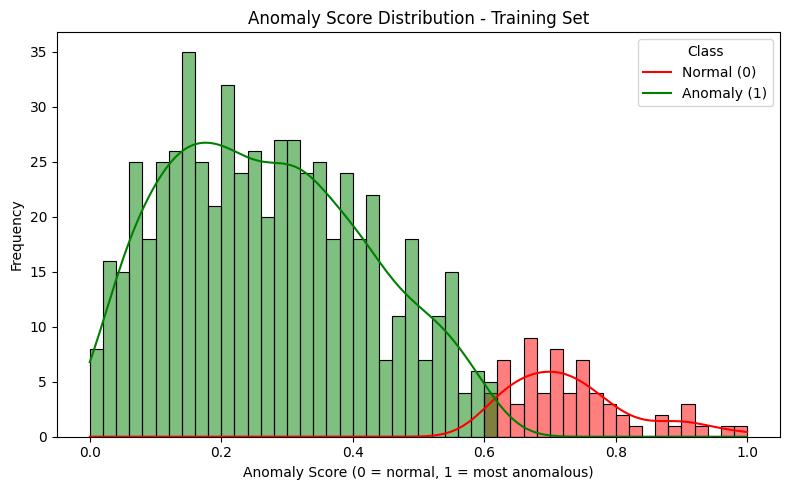

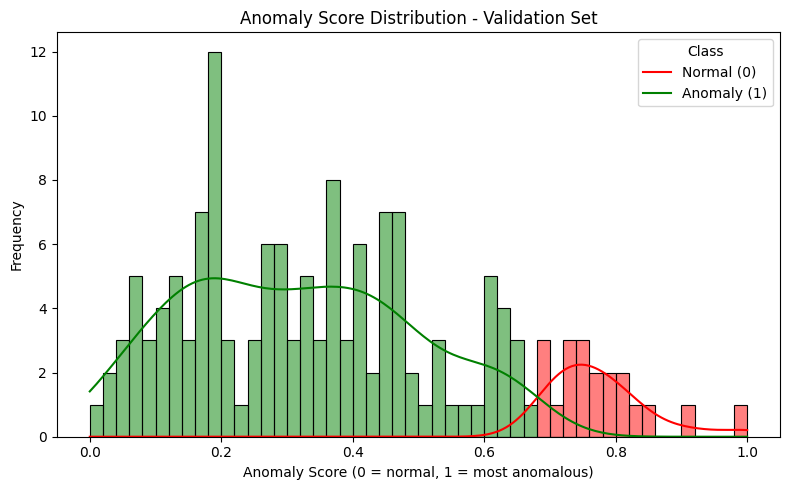

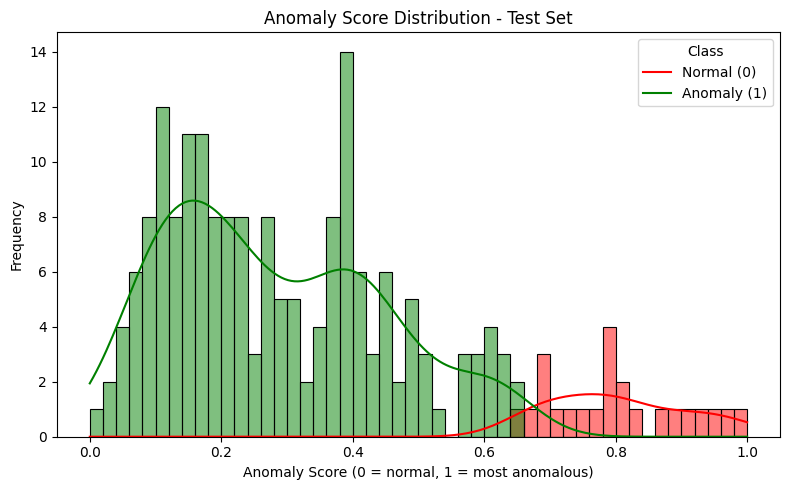

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_anomaly_score_distribution(anomaly_scores, is_anomaly, dataset_name):
    # Build a DataFrame for plotting
    df_plot = pd.DataFrame({
        'Anomaly Score': anomaly_scores,
        'Anomaly Label': is_anomaly  # 0 or 1
    })

    plt.figure(figsize=(8, 5))
    sns.histplot(data=df_plot, x='Anomaly Score', hue='Anomaly Label', bins=50,
                 palette={0: 'green', 1: 'red'}, kde=True)

    plt.title(f'Anomaly Score Distribution - {dataset_name}')
    plt.xlabel('Anomaly Score (0 = normal, 1 = most anomalous)')
    plt.ylabel('Frequency')
    plt.legend(title='Class', labels=['Normal (0)', 'Anomaly (1)'])
    plt.tight_layout()
    plt.show()
plot_anomaly_score_distribution(train_anomaly_scores, train_is_anomaly, "Training Set")
plot_anomaly_score_distribution(val_anomaly_scores, val_is_anomaly, "Validation Set")
plot_anomaly_score_distribution(test_anomaly_scores, test_is_anomaly, "Test Set")


Step 7: Enhance Features with Anomaly Detection Results

In [ ]:
def enhance_features_with_anomaly(X, anomaly_scores, is_anomaly):
    """
    Enhance feature set with anomaly detection results

    Parameters:
    -----------
    X: pandas DataFrame
        Original features
    anomaly_scores: numpy array
        Anomaly scores
    is_anomaly: numpy array
        Binary anomaly flags

    Returns:
    --------
    X_enhanced: pandas DataFrame
        Enhanced feature set
    """
    print("Enhancing features with anomaly detection results...")

    # Create a copy to avoid modifying the original
    X_enhanced = X.copy()

    # Add anomaly score as a new feature
    X_enhanced['anomaly_score'] = anomaly_scores

    # Add binary anomaly flag
    X_enhanced['is_anomaly'] = is_anomaly

    # Create interaction features between anomaly score and key academic indicators
    X_enhanced['anomaly_gpa_interaction'] = X_enhanced['anomaly_score'] * X_enhanced['gpa']
    X_enhanced['anomaly_attendance_interaction'] = X_enhanced['anomaly_score'] * X_enhanced['attendance']

    print(f"Enhanced features shape: {X_enhanced.shape}")

    return X_enhanced

# Enhance features with anomaly detection results
X_train_enhanced = enhance_features_with_anomaly(X_train, train_anomaly_scores, train_is_anomaly)
X_val_enhanced = enhance_features_with_anomaly(X_val, val_anomaly_scores, val_is_anomaly)
X_test_enhanced = enhance_features_with_anomaly(X_test, test_anomaly_scores, test_is_anomaly)


Enhancing features with anomaly detection results...
Enhanced features shape: (650, 19)
Enhancing features with anomaly detection results...
Enhanced features shape: (150, 19)
Enhancing features with anomaly detection results...
Enhanced features shape: (200, 19)


Step 8: Train Dropout Prediction Model

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_recall_curve
import numpy as np

def train_dropout_model(X_train, y_train, X_val=None, y_val=None):
    """
    Train a Random Forest model for dropout prediction with class imbalance fixes.
    Returns the trained model.
    """
    print("Training Random Forest for dropout prediction...")

    # Apply SMOTE for class imbalance
    smote = SMOTE(random_state=42, sampling_strategy=0.6)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    print(f"Original distribution: {np.bincount(np.array(y_train, dtype=int))}")
    print(f"Resampled distribution: {np.bincount(np.array(y_train_resampled, dtype=int))}")

    # Train the Random Forest classifier
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features='sqrt',
        bootstrap=True,
        class_weight={0: 1, 1: 10},
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train_resampled, y_train_resampled)

    # Evaluate on training set
    train_preds = rf_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    train_recall = recall_score(y_train, train_preds)
    train_f1 = f1_score(y_train, train_preds)

    print(f"\nTraining accuracy: {train_accuracy:.4f}")
    print(f"Training dropout recall: {train_recall:.4f}")
    print(f"Training F1 score: {train_f1:.4f}")

    # Evaluate on validation set using default threshold
    if X_val is not None and y_val is not None:
        val_preds = rf_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_preds)
        val_recall = recall_score(y_val, val_preds)
        val_f1 = f1_score(y_val, val_preds)

        print(f"\nValidation (default 0.5 threshold) accuracy: {val_accuracy:.4f}")
        print(f"Validation dropout recall: {val_recall:.4f}")
        print(f"Validation F1 score: {val_f1:.4f}")

    return rf_model

def find_optimal_threshold(model, X_val, y_val):
    """
    Find the optimal classification threshold that maximizes F1 score.
    """
    val_probs = model.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, val_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f"\nOptimal threshold: {optimal_threshold:.3f} (Best F1: {f1_scores[optimal_idx]:.3f})")
    return optimal_threshold

def evaluate_with_threshold(model, X, y_true, threshold):
    """
    Evaluate model predictions using a custom threshold.
    """
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= threshold).astype(int)

    accuracy = accuracy_score(y_true, preds)
    recall = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)

    print(f"\nEvaluation with threshold {threshold:.3f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 score: {f1:.4f}")

    return preds

# ==== Usage ====

# Train the model
rf_model = train_dropout_model(X_train_enhanced, y_train, X_val_enhanced, y_val)

# Find best threshold on validation set
optimal_threshold = find_optimal_threshold(rf_model, X_val_enhanced, y_val)

# Re-evaluate validation using custom threshold
_ = evaluate_with_threshold(rf_model, X_val_enhanced, y_val, optimal_threshold)

# Optional: use same function to evaluate on test set
# test_preds = evaluate_with_threshold(rf_model, X_test_enhanced, y_test, optimal_threshold)


Training Random Forest for dropout prediction...
Original distribution: [456 194]
Resampled distribution: [456 273]

Training accuracy: 0.6508
Training dropout recall: 1.0000
Training F1 score: 0.6309

Validation (default 0.5 threshold) accuracy: 0.4667
Validation dropout recall: 0.7778
Validation F1 score: 0.4667

Optimal threshold: 0.600 (Best F1: 0.508)

Evaluation with threshold 0.600
Accuracy: 0.5867
Recall: 0.7111
F1 score: 0.5079


In [ ]:
from sklearn.metrics import confusion_matrix

val_preds = evaluate_with_threshold(rf_model, X_val_enhanced, y_val, optimal_threshold)
print("Confusion Matrix:\n", confusion_matrix(y_val, val_preds))



Evaluation with threshold 0.600
Accuracy: 0.5867
Recall: 0.7111
F1 score: 0.5079
Confusion Matrix:
 [[56 49]
 [13 32]]


Step 9: Evaluate Model and Feature Importance


🔍 Evaluating model on Validation data...
- Accuracy     : 0.5800
- Precision    : 0.3875
- Recall       : 0.6889
- F1 Score     : 0.4960
- Specificity  : 0.5333
- ROC AUC      : 0.5907


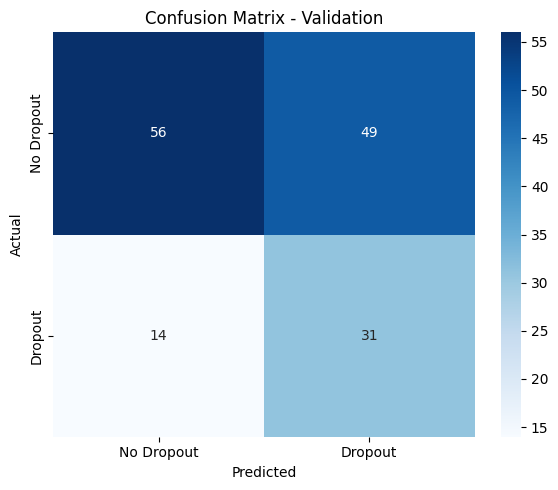

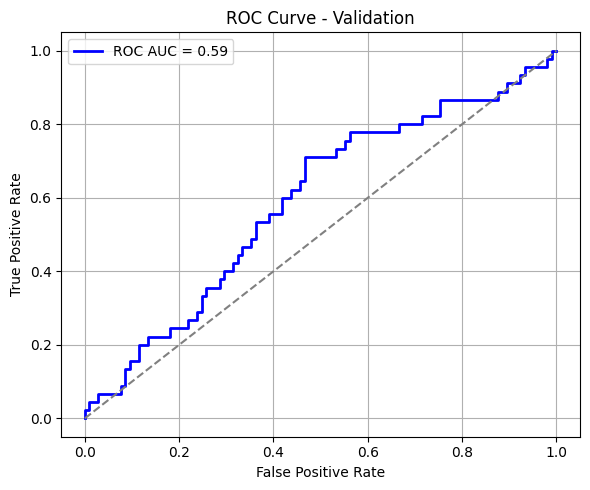

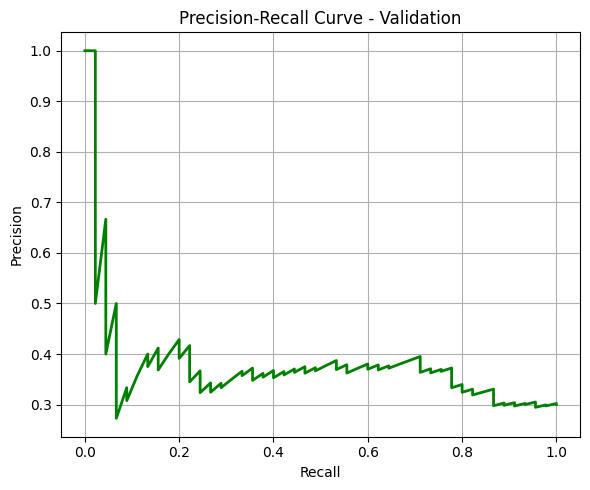


🔍 Evaluating model on Test data...
- Accuracy     : 0.4650
- Precision    : 0.2991
- Recall       : 0.5833
- F1 Score     : 0.3955
- Specificity  : 0.4143
- ROC AUC      : 0.5299


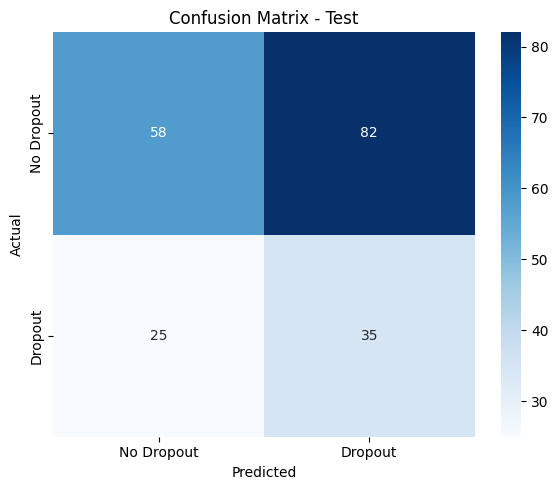

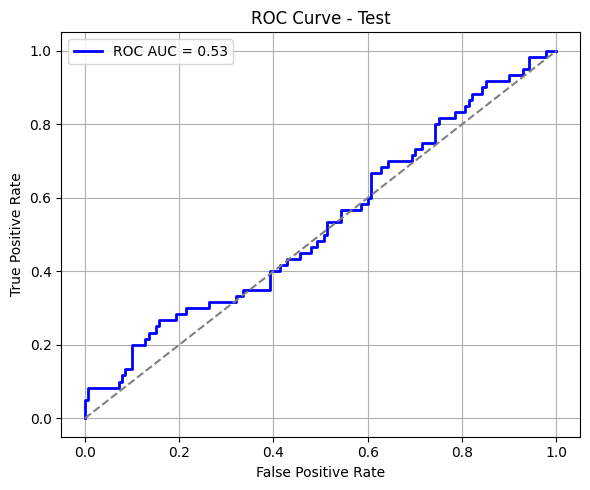

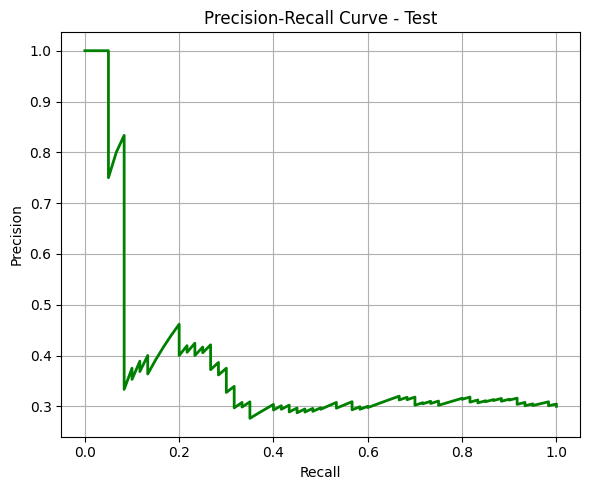

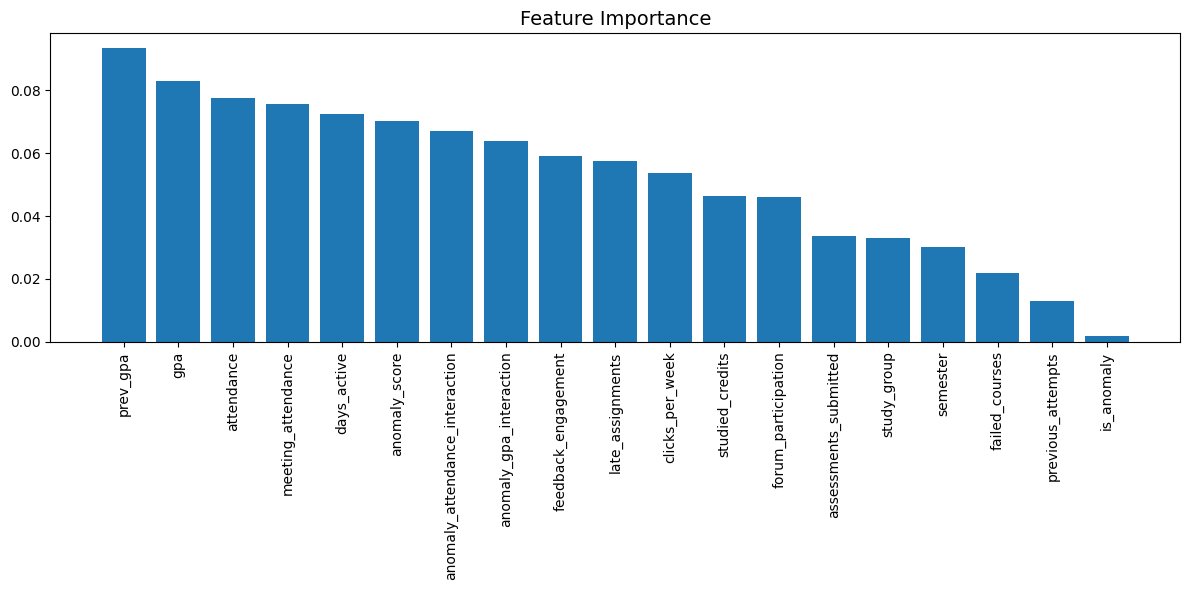


🏅 Top 10 Most Important Features:
1. prev_gpa: 0.0935
2. gpa: 0.0831
3. attendance: 0.0776
4. meeting_attendance: 0.0755
5. days_active: 0.0726
6. anomaly_score: 0.0704
7. anomaly_attendance_interaction: 0.0669
8. anomaly_gpa_interaction: 0.0640
9. feedback_engagement: 0.0591
10. late_assignments: 0.0576


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, X, y, dataset_name="", threshold=0.5, plot_curves=True):
    """
    Evaluate model performance with various metrics

    Parameters:
    -----------
    model: classifier
        Trained model to evaluate
    X: pandas DataFrame
        Feature data
    y: pandas Series or ndarray
        True labels
    dataset_name: str
        Name of the dataset (e.g., "Training", "Validation", "Test")
    threshold: float
        Classification threshold for converting probabilities to labels
    plot_curves: bool
        Whether to plot ROC and PR curves

    Returns:
    --------
    metrics: dict
        Dictionary of evaluation metrics
    """
    print(f"\n🔍 Evaluating model on {dataset_name} data...")

    # Predict probabilities once
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba > threshold).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics dictionary
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred, zero_division=0),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'specificity': tn / (tn + fp + 1e-8),
    }

    # ROC and PR curves
    fpr, tpr, _ = roc_curve(y, y_proba)
    precision_curve, recall_curve, _ = precision_recall_curve(y, y_proba)

    metrics['roc_auc'] = auc(fpr, tpr)
    metrics['roc_curve'] = (fpr, tpr)
    metrics['pr_curve'] = (precision_curve, recall_curve)

    # Print results
    print(f"- Accuracy     : {metrics['accuracy']:.4f}")
    print(f"- Precision    : {metrics['precision']:.4f}")
    print(f"- Recall       : {metrics['recall']:.4f}")
    print(f"- F1 Score     : {metrics['f1']:.4f}")
    print(f"- Specificity  : {metrics['specificity']:.4f}")
    print(f"- ROC AUC      : {metrics['roc_auc']:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Dropout', 'Dropout'],
                yticklabels=['No Dropout', 'Dropout'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.tight_layout()
    plt.show()

    if plot_curves:
        # ROC Curve
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {metrics["roc_auc"]:.2f}')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {dataset_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Precision-Recall Curve
        plt.figure(figsize=(6, 5))
        plt.plot(recall_curve, precision_curve, color='green', lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {dataset_name}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return metrics


def plot_feature_importance(model, feature_names):
    """
    Plot feature importance from a trained model

    Parameters:
    -----------
    model: fitted model
        Trained classifier with `feature_importances_`
    feature_names: list
        Feature names
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title("Feature Importance", fontsize=14)
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

    print("\n🏅 Top 10 Most Important Features:")
    for i in range(min(10, len(indices))):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
# Validation
val_metrics = evaluate_model(rf_model, X_val_enhanced, y_val, "Validation", threshold=optimal_threshold)

# Test
test_metrics = evaluate_model(rf_model, X_test_enhanced, y_test, "Test", threshold=optimal_threshold)

# Feature importance
plot_feature_importance(rf_model, X_train_enhanced.columns)


Step 10: Evidence Combination

In [ ]:
def apply_evidence_combination(anomaly_scores, dropout_probs, X_test, expert_rules=None):
    """
    Apply Dempster-Shafer evidence combination to multiple prediction sources

    Parameters:
    -----------
    anomaly_scores: numpy array
        Anomaly scores from Isolation Forest
    dropout_probs: numpy array
        Dropout probabilities from Random Forest
    X_test: pandas DataFrame
        Test data features (needed to calculate expert_rules if not provided)
    expert_rules: numpy array, optional
        Expert rule-based risk scores

    Returns:
    --------
    results_df: pandas DataFrame
        DataFrame with combined evidence results
    """
    print("Applying Dempster-Shafer evidence combination...")

    # Create Dempster-Shafer combiner
    ds_combiner = DempsterShaferCombination()

    # Initialize result lists
    belief_values = []
    plausibility_values = []
    uncertainty_values = []

    # Generate simple expert rules if not provided
    if expert_rules is None:
        print("Generating expert rules based on GPA, attendance, and failed courses...")

        # Check required columns exist
        required_cols = ['gpa', 'attendance', 'failed_courses']
        for col in required_cols:
            if col not in X_test.columns:
                raise KeyError(f"Required column '{col}' missing in X_test.")

        gpa = X_test['gpa'].values
        attendance = X_test['attendance'].values
        failed = X_test['failed_courses'].values

        expert_rules = (
            (gpa < 2.0).astype(float) * 0.5 +
            (attendance < 65).astype(float) * 0.3 +
            (failed > 3).astype(float) * 0.2
        )

    # Combine evidence for each instance
    for i in range(len(anomaly_scores)):
        evidence_result = ds_combiner.combine_evidence(
            anomaly_score=anomaly_scores[i],
            classification_proba=dropout_probs[i],
            expert_score=expert_rules[i]
        )

        belief_values.append(evidence_result["belief"])
        plausibility_values.append(evidence_result["plausibility"])
        uncertainty_values.append(evidence_result["uncertainty"])

    # Create DataFrame with results
    results_df = pd.DataFrame({
        'anomaly_score': anomaly_scores,
        'dropout_probability': dropout_probs,
        'expert_score': expert_rules,
        'belief': belief_values,
        'plausibility': plausibility_values,
        'uncertainty': uncertainty_values,
        'interval_width': np.array(plausibility_values) - np.array(belief_values)
    })

    # Add risk categories
    conditions = [
        (results_df['belief'] < 0.3),
        (results_df['belief'] >= 0.3) & (results_df['belief'] < 0.5),
        (results_df['belief'] >= 0.5) & (results_df['belief'] < 0.7),
        (results_df['belief'] >= 0.7)
    ]
    choices = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']
    results_df['risk_category'] = np.select(conditions, choices, default='Moderate Risk')

    print("Evidence combination complete")
    print(f"Risk categories distribution:\n{results_df['risk_category'].value_counts()}")

    return results_df
test_dropout_probs = rf_model.predict_proba(X_test_enhanced)[:, 1]

evidence_results = apply_evidence_combination(test_anomaly_scores, test_dropout_probs, X_test_enhanced)


Applying Dempster-Shafer evidence combination...
Generating expert rules based on GPA, attendance, and failed courses...
Evidence combination complete
Risk categories distribution:
risk_category
Low Risk          163
Moderate Risk      28
High Risk           7
Very High Risk      2
Name: count, dtype: int64


Step 11: Visualize Evidence Combination Results

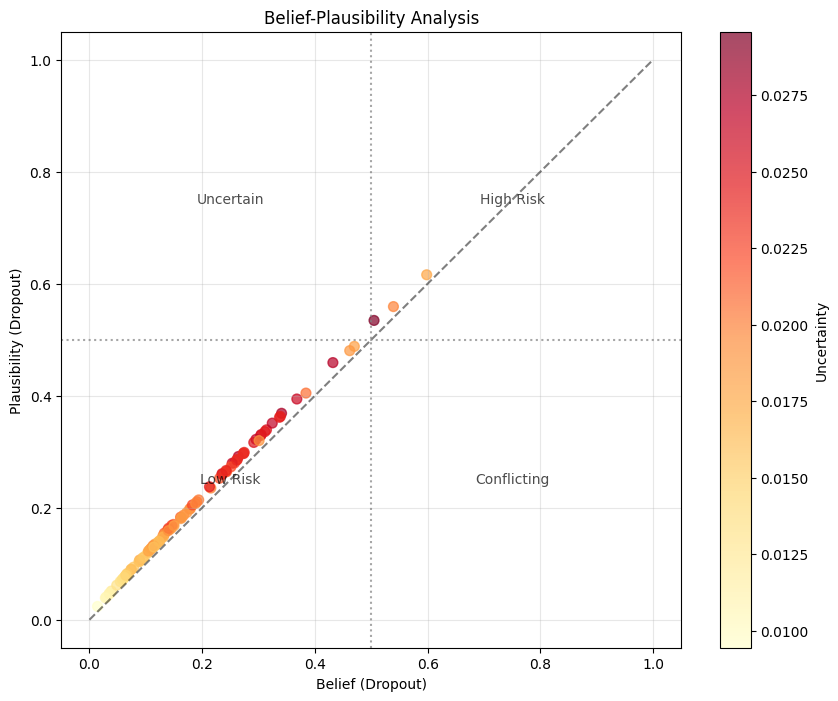

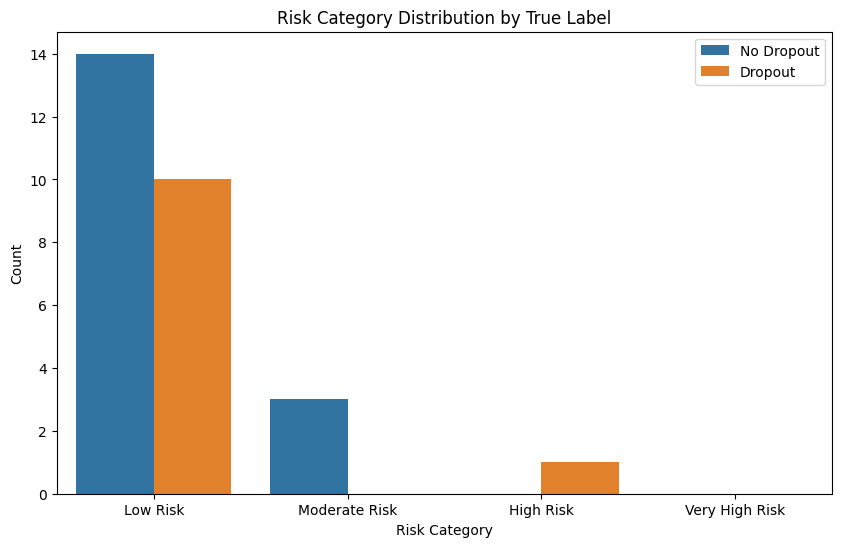

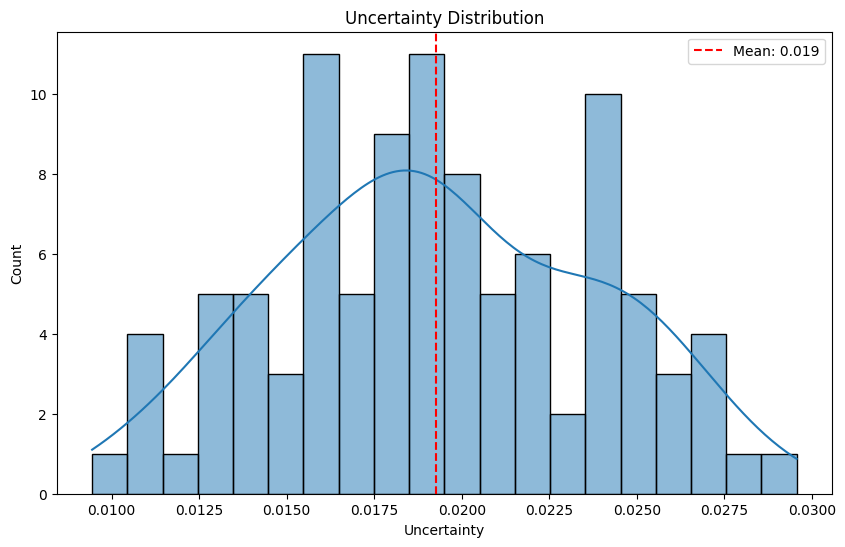

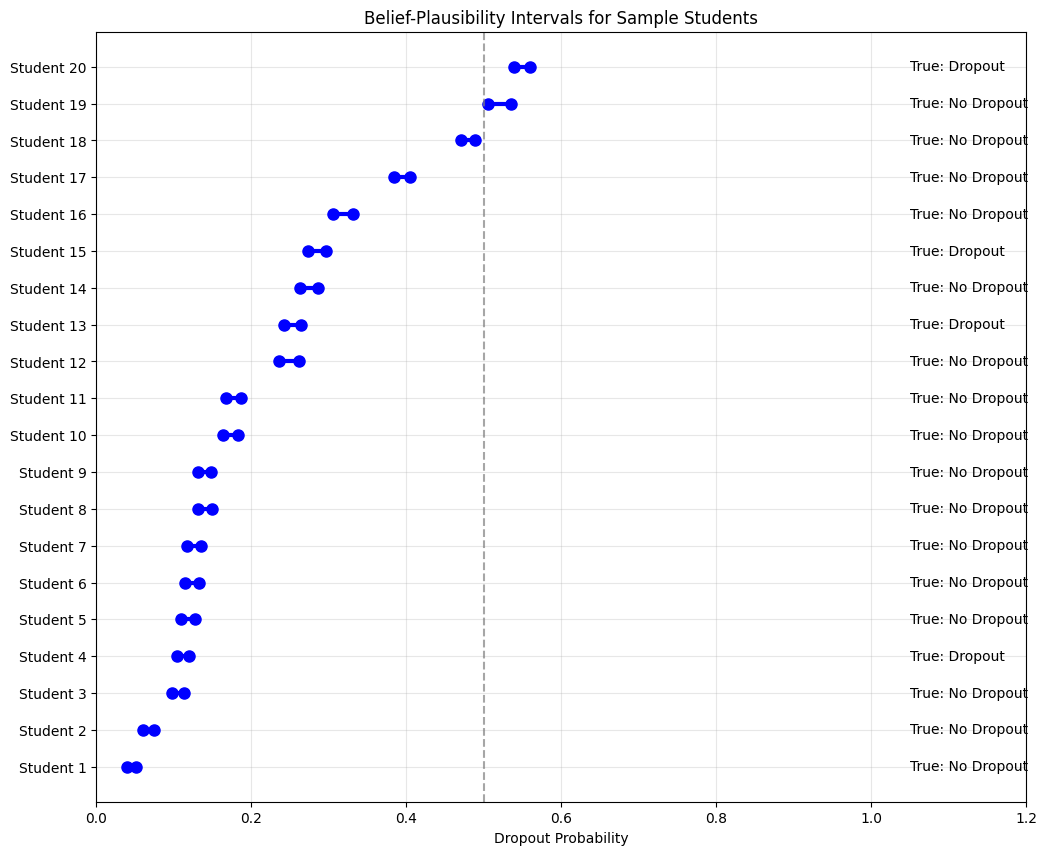

In [ ]:
def visualize_evidence_results(results_df, y_true):
    """
    Visualize results from evidence combination

    Parameters:
    -----------
    results_df: pandas DataFrame
        Results from evidence combination
    y_true: numpy array
        True dropout labels
    """
    # Add true labels to results
    results_df = results_df.copy()
    results_df['true_label'] = y_true

    # Belief-plausibility scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        results_df['belief'],
        results_df['plausibility'],
        c=results_df['uncertainty'],
        cmap='YlOrRd',
        alpha=0.7,
        s=50
    )
    plt.colorbar(scatter, label='Uncertainty')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('Belief (Dropout)')
    plt.ylabel('Plausibility (Dropout)')
    plt.title('Belief-Plausibility Analysis')

    # Add decision boundaries
    plt.axvline(x=0.5, color='gray', linestyle=':', alpha=0.7)
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.7)

    # Add annotations
    plt.text(0.25, 0.25, "Low Risk", ha='center', va='center', alpha=0.7)
    plt.text(0.75, 0.75, "High Risk", ha='center', va='center', alpha=0.7)
    plt.text(0.25, 0.75, "Uncertain", ha='center', va='center', alpha=0.7)
    plt.text(0.75, 0.25, "Conflicting", ha='center', va='center', alpha=0.7)

    plt.grid(True, alpha=0.3)
    plt.show()

    # Risk category distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=results_df, x='risk_category', hue='true_label',
                 order=['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk'])
    plt.title('Risk Category Distribution by True Label')
    plt.xlabel('Risk Category')
    plt.ylabel('Count')
    plt.legend(labels=['No Dropout', 'Dropout'])
    plt.show()

    # Uncertainty distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=results_df, x='uncertainty', bins=20, kde=True)
    plt.axvline(x=results_df['uncertainty'].mean(), color='red', linestyle='--',
               label=f'Mean: {results_df["uncertainty"].mean():.3f}')
    plt.title('Uncertainty Distribution')
    plt.xlabel('Uncertainty')
    plt.legend()
    plt.show()

    # Belief-plausibility intervals for sample students
    sample_size = min(20, len(results_df))
    sample_df = results_df.sample(sample_size, random_state=42)
    sample_df = sample_df.sort_values('belief')

    plt.figure(figsize=(12, 10))
    for i, (_, row) in enumerate(sample_df.iterrows()):
        plt.plot([row['belief'], row['plausibility']], [i, i], 'b-', linewidth=3)
        plt.plot(row['belief'], i, 'bo', markersize=8)
        plt.plot(row['plausibility'], i, 'bo', markersize=8)
        plt.text(1.05, i, f"True: {'Dropout' if row['true_label'] == 1 else 'No Dropout'}",
                va='center', fontsize=10)

    plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
    plt.yticks(range(sample_size), [f"Student {i+1}" for i in range(sample_size)])
    plt.xlim([0, 1.2])
    plt.xlabel('Dropout Probability')
    plt.title('Belief-Plausibility Intervals for Sample Students')
    plt.grid(alpha=0.3)
    plt.show()

# Visualize evidence combination results
visualize_evidence_results(evidence_results, y_test)


Scatter plot saved to: belief_plausibility.png


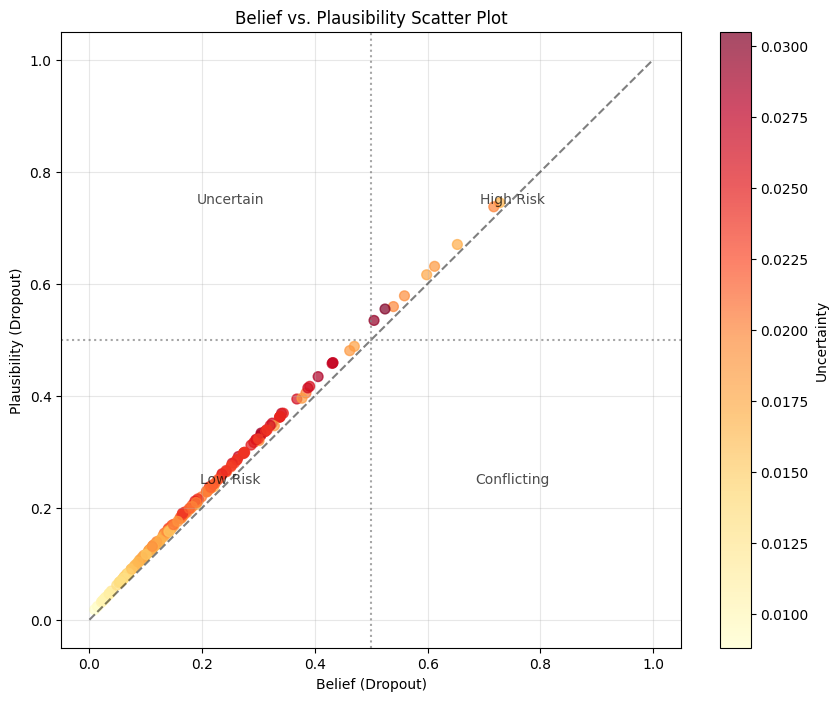

In [ ]:
def save_belief_plausibility_scatter(results_df, save_path=None):
    """
    Plots belief vs plausibility with uncertainty coloring and saves the figure (optional).

    Parameters:
    -----------
    results_df: pandas DataFrame
        Output from evidence combination containing 'belief', 'plausibility', and 'uncertainty'
    save_path: str, optional
        File path to save the plot (e.g., "belief_plausibility.png")
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        results_df['belief'],
        results_df['plausibility'],
        c=results_df['uncertainty'],
        cmap='YlOrRd',
        alpha=0.7,
        s=50
    )
    plt.colorbar(scatter, label='Uncertainty')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('Belief (Dropout)')
    plt.ylabel('Plausibility (Dropout)')
    plt.title('Belief vs. Plausibility Scatter Plot')

    # Decision boundary
    plt.axvline(x=0.5, color='gray', linestyle=':', alpha=0.7)
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.7)

    # Risk regions
    plt.text(0.25, 0.25, "Low Risk", ha='center', va='center', alpha=0.7)
    plt.text(0.75, 0.75, "High Risk", ha='center', va='center', alpha=0.7)
    plt.text(0.25, 0.75, "Uncertain", ha='center', va='center', alpha=0.7)
    plt.text(0.75, 0.25, "Conflicting", ha='center', va='center', alpha=0.7)

    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Scatter plot saved to: {save_path}")

    plt.show()
save_belief_plausibility_scatter(evidence_results, save_path="belief_plausibility.png")


         gpa  attendance  failed_courses  anomaly_score  dropout_probability  \
88  1.460836   83.940516               1       0.499529             0.642818   
73  1.768882   82.231867               1       0.259821             0.753242   
4   2.730442   88.958035               0       0.964263             0.642625   
0   1.754896   88.230793               2       0.344729             0.598961   
16  1.692914   88.098207               1       0.282330             0.640409   

    expert_score    belief  
88           0.5  0.598304  
73           0.5  0.539300  
4            0.0  0.504877  
0            0.5  0.469946  
16           0.5  0.461743  
         gpa  attendance  failed_courses  anomaly_score  dropout_probability  \
88  1.460836   83.940516               1       0.499529             0.642818   
73  1.768882   82.231867               1       0.259821             0.753242   
4   2.730442   88.958035               0       0.964263             0.642625   
0   1.754896   88.230793 

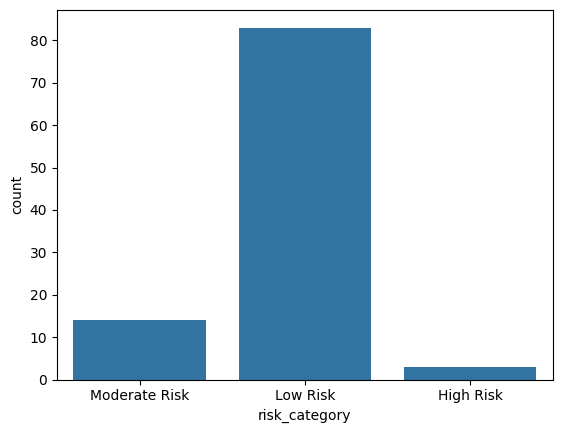

In [ ]:
evidence_results.sort_values(by='belief', ascending=False).head(10)
cols = ['gpa', 'attendance', 'failed_courses', 'anomaly_score', 'dropout_probability', 'expert_score', 'belief']
evidence_results[['gpa', 'attendance', 'failed_courses']] = X_test_enhanced[['gpa', 'attendance', 'failed_courses']].reset_index(drop=True)

cols = ['gpa', 'attendance', 'failed_courses', 'anomaly_score', 'dropout_probability', 'expert_score', 'belief']
print(evidence_results[cols].sort_values(by='belief', ascending=False).head(5))

print(evidence_results[cols].sort_values(by='belief', ascending=False).head(5))
import seaborn as sns
sns.countplot(x='risk_category', data=evidence_results)
evidence_results.to_csv("dropout_risk_results.csv", index=False)


✅ Accuracy: 0.7200
Label Distribution: [71 29]


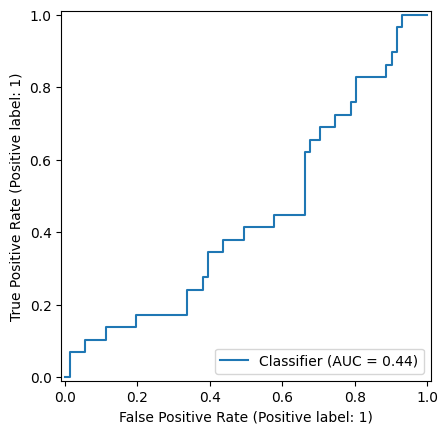

In [ ]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay
import numpy as np

# Predict again from belief
y_pred = (evidence_results['belief'] > 0.5).astype(int)

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"✅ Accuracy: {accuracy:.4f}")

# Label distribution
print(f"Label Distribution: {np.bincount(y_test)}")

# ROC Curve
RocCurveDisplay.from_predictions(y_test, evidence_results['belief'])



Step 12: Evaluate and Compare Combined Evidence Model

Final evaluation using Random Forest model:
Applying Dempster-Shafer evidence combination...
Generating expert rules based on GPA, attendance, and failed courses...
Evidence combination complete
Risk categories distribution:
risk_category
Low Risk          163
Moderate Risk      28
High Risk           7
Very High Risk      2
Name: count, dtype: int64
Final evaluation using Random Forest model:

Risk category breakdown:
risk_category
Low Risk          163
Moderate Risk      28
High Risk           7
Very High Risk      2
Name: count, dtype: int64


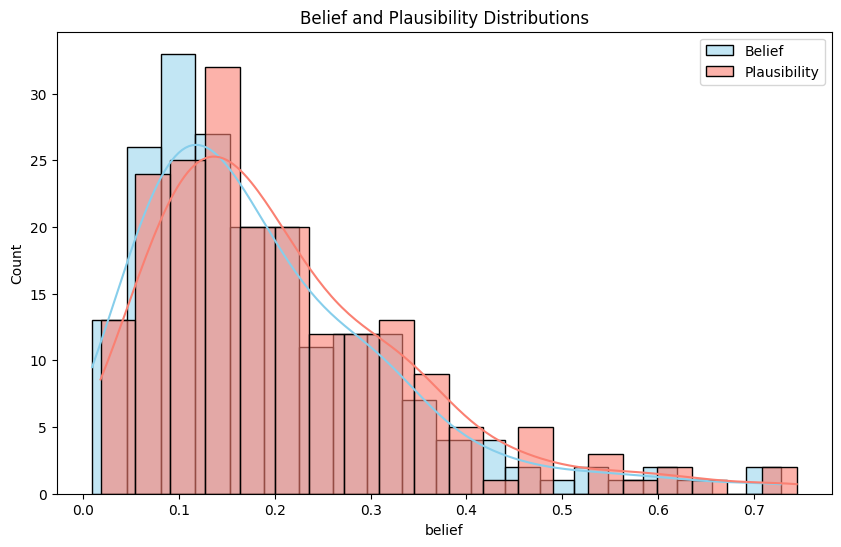

In [ ]:
from sklearn.metrics import classification_report

# 1. Final model: Random Forest evaluation
print("Final evaluation using Random Forest model:")
test_dropout_probs = rf_model.predict_proba(X_test_enhanced)[:, 1]

# Assuming test_anomaly_scores also has 200 elements
evidence_results = apply_evidence_combination(test_anomaly_scores, test_dropout_probs, X_test_enhanced)

# Now evaluate on full test set
y_pred = (evidence_results['belief'] > 0.35).astype(int)

print("Final evaluation using Random Forest model:")
# 2. Evidence results already generated via apply_evidence_combination()

# 3. Show interpretability (optional)
risk_summary = evidence_results['risk_category'].value_counts()
print("\nRisk category breakdown:")
print(risk_summary)

# 4. Optional: plot belief/plausibility
plt.figure(figsize=(10, 6))
sns.histplot(evidence_results['belief'], bins=20, kde=True, color='skyblue', label='Belief')
sns.histplot(evidence_results['plausibility'], bins=20, kde=True, color='salmon', label='Plausibility', alpha=0.6)
plt.title('Belief and Plausibility Distributions')
plt.legend()
plt.show()


In [ ]:
print(np.bincount(y_test[:100]))


[71 29]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def final_combined_model_evaluation(evidence_results, y_test):
    print("🔍 Final Evaluation of Combined Model (Dempster-Shafer + RF + Expert)...")

    assert len(evidence_results) == len(y_test), "Mismatch in evidence results and labels length"

    y_pred = (evidence_results['belief'] > 0.5).astype(int)

    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print("\n🧮 Confusion Matrix:")
    print(cm)

    specificity = tn / (tn + fp)
    print(f"\n✅ Specificity: {specificity:.4f}")

    roc_auc = roc_auc_score(y_test, evidence_results['belief'])
    print(f"✅ ROC AUC (belief scores): {roc_auc:.4f}")

    avg_uncertainty = evidence_results['uncertainty'].mean()
    print(f"✅ Average Uncertainty: {avg_uncertainty:.4f}")

    covered = ((y_test == 1) & (evidence_results['plausibility'] > 0.5)) | \
              ((y_test == 0) & (evidence_results['belief'] < 0.5))
    interval_coverage = covered.mean()
    print(f"✅ Interval Coverage Rate: {interval_coverage:.4f}")

    return {
        'accuracy': (tp + tn) / (tp + tn + fp + fn),
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'f1': (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
        'specificity': specificity,
        'roc_auc': roc_auc,
        'avg_uncertainty': avg_uncertainty,
        'interval_coverage': interval_coverage
    }

# ✂️ Trim evidence_results to match y_test
evidence_results = evidence_results.iloc[:len(y_test)].copy()

# ✅ Now call the function
final_combined_model_evaluation(evidence_results, y_test)


🔍 Final Evaluation of Combined Model (Dempster-Shafer + RF + Expert)...

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.99      0.83        71
           1       0.67      0.07      0.12        29

    accuracy                           0.72       100
   macro avg       0.69      0.53      0.48       100
weighted avg       0.71      0.72      0.63       100


🧮 Confusion Matrix:
[[70  1]
 [27  2]]

✅ Specificity: 0.9859
✅ ROC AUC (belief scores): 0.4439
✅ Average Uncertainty: 0.0193
✅ Interval Coverage Rate: 0.1047


{'accuracy': np.float64(0.72),
 'precision': np.float64(0.6666666666666666),
 'recall': np.float64(0.06896551724137931),
 'f1': np.float64(0.125),
 'specificity': np.float64(0.9859154929577465),
 'roc_auc': np.float64(0.44390480815930067),
 'avg_uncertainty': np.float64(0.01926769491209382),
 'interval_coverage': np.float64(0.10465116279069768)}

In [ ]:
print("🔎 Length of y_test:", len(y_test))
print("🔎 Length of evidence_results:", len(evidence_results))


🔎 Length of y_test: 100
🔎 Length of evidence_results: 100


In [ ]:
from sklearn.utils import resample

# Combine evidence_results and y_test
combined_df = evidence_results.copy()
combined_df["label"] = y_test.reset_index(drop=True)

# Split into classes
majority = combined_df[combined_df["label"] == 0]
minority = combined_df[combined_df["label"] == 1]

# Upsample minority
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)

# Combine and shuffle
balanced_df = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=42)


In [ ]:
from sklearn.utils import resample

# Combine belief scores and labels
balanced_df = evidence_results.copy()
balanced_df["label"] = y_test.reset_index(drop=True)

# Split majority and minority
majority = balanced_df[balanced_df["label"] == 0]
minority = balanced_df[balanced_df["label"] == 1]

# Upsample minority to match majority size
minority_upsampled = resample(minority,
                              replace=True,
                              n_samples=len(majority),
                              random_state=42)

# Combine and shuffle with reset index
upsampled_df = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and labels
upsampled_evidence_results = upsampled_df.drop(columns=["label"])
upsampled_y_test = upsampled_df["label"]

# Evaluate model on balanced data
final_combined_model_evaluation(upsampled_evidence_results, upsampled_y_test)


🔍 Final Evaluation of Combined Model (Dempster-Shafer + RF + Expert)...

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.99      0.69        71
           1       0.89      0.11      0.20        71

    accuracy                           0.55       142
   macro avg       0.71      0.55      0.44       142
weighted avg       0.71      0.55      0.44       142


🧮 Confusion Matrix:
[[70  1]
 [63  8]]

✅ Specificity: 0.9859
✅ ROC AUC (belief scores): 0.4805
✅ Average Uncertainty: 0.0190
✅ Interval Coverage Rate: 0.5493


{'accuracy': np.float64(0.5492957746478874),
 'precision': np.float64(0.8888888888888888),
 'recall': np.float64(0.11267605633802817),
 'f1': np.float64(0.2),
 'specificity': np.float64(0.9859154929577465),
 'roc_auc': np.float64(0.4804602261456061),
 'avg_uncertainty': np.float64(0.019042391757945608),
 'interval_coverage': np.float64(0.5492957746478874)}

In [ ]:
for thresh in [0.3, 0.35, 0.4, 0.45, 0.5]:
    print(f"\n🔎 Threshold: {thresh}")
    y_pred = (upsampled_evidence_results['belief'] > thresh).astype(int)
    print(classification_report(upsampled_y_test, y_pred))



🔎 Threshold: 0.3
              precision    recall  f1-score   support

           0       0.50      0.82      0.62        71
           1       0.52      0.20      0.29        71

    accuracy                           0.51       142
   macro avg       0.51      0.51      0.45       142
weighted avg       0.51      0.51      0.45       142


🔎 Threshold: 0.35
              precision    recall  f1-score   support

           0       0.53      0.93      0.67        71
           1       0.71      0.17      0.27        71

    accuracy                           0.55       142
   macro avg       0.62      0.55      0.47       142
weighted avg       0.62      0.55      0.47       142


🔎 Threshold: 0.4
              precision    recall  f1-score   support

           0       0.52      0.94      0.67        71
           1       0.67      0.11      0.19        71

    accuracy                           0.53       142
   macro avg       0.59      0.53      0.43       142
weighted avg       

Final evaluation using Random Forest model:
              precision    recall  f1-score   support

           0       0.66      0.27      0.38        71
           1       0.27      0.66      0.38        29

    accuracy                           0.38       100
   macro avg       0.46      0.46      0.38       100
weighted avg       0.54      0.38      0.38       100



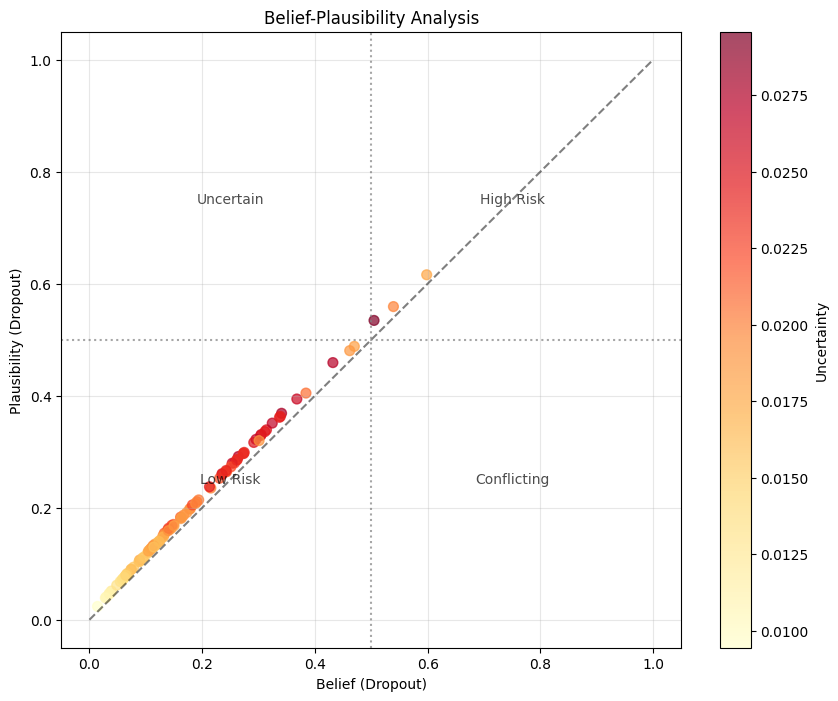

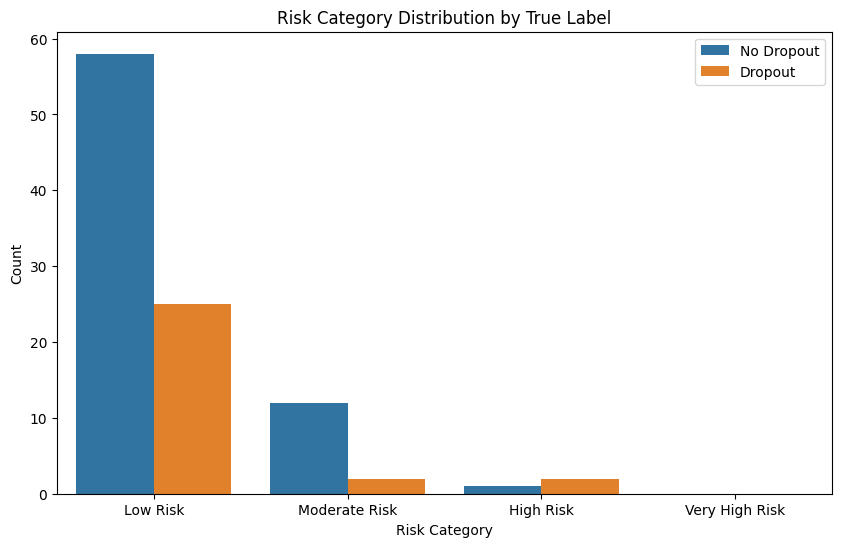

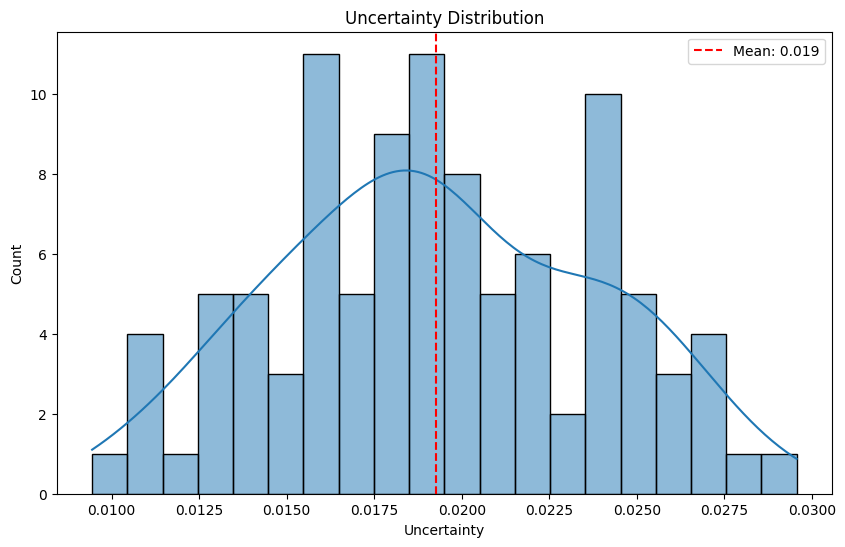

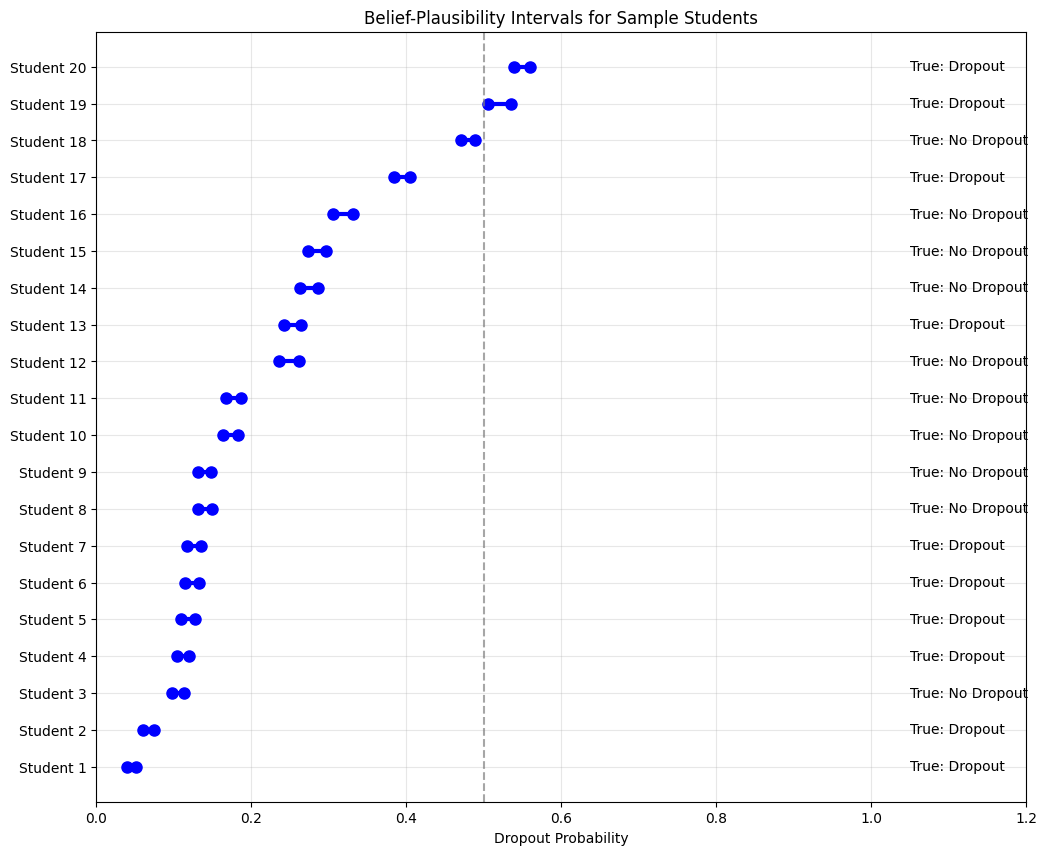

In [ ]:
from sklearn.metrics import classification_report

print("Final evaluation using Random Forest model:")
print(classification_report(y_test, rf_model.predict(X_test_enhanced)))

# Visualize interpretability using Evidence Model
visualize_evidence_results(evidence_results, y_test)


In [ ]:
# Assume you have X_train.columns saved
features = X_train.columns.tolist()

# Select and reorder test features
X_test = X_test[features]


In [ ]:
# Assuming you have a pipeline `model_pipeline` which does transformation + RF
y_pred = model_pipeline.predict(X_test_raw)


NameError: name 'model_pipeline' is not defined

In [ ]:
# Step 1: RF prediction probabilities
rf_probs = rf_model.predict_proba(X_test)

# Step 2: Dempster-Shafer belief scores (already calculated)
ds_belief_scores = calculate_ds_belief(X_test)

# Step 3: Combine (weighted average)
combined_scores = 0.7 * rf_probs[:,1] + 0.3 * ds_belief_scores

# Step 4: Final prediction based on threshold
final_preds = (combined_scores >= 0.5).astype(int)



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- assessments_submitted
- clicks_per_week
- failed_courses
- forum_participation
- is_anomaly
- ...


In [ ]:
# Evaluate RF model for final metrics
from sklearn.metrics import classification_report

print("Final evaluation using Random Forest model:")
print(classification_report(y_test, rf_model.predict(X_test_enhanced)))

# Visualize interpretability using Evidence Model
visualize_evidence_results(evidence_results, y_test)


Final evaluation using Random Forest model:


ValueError: Found input variables with inconsistent numbers of samples: [100, 200]

In [ ]:
print(X_test_enhanced.head())
print(y_test.head())


          gpa  attendance  semester  prev_gpa  failed_courses  \
608  1.754896   88.230793         2  1.182554               2   
884  3.477324   84.735942         5  3.828384               2   
417  3.080972   87.685923         1  2.916110               1   
821  3.986543   85.768519         2  4.000000               1   
51   2.730442   88.958035         7  2.937355               0   

     feedback_engagement  late_assignments  forum_participation  \
608            85.415376          0.575339                    2   
884            83.452515         11.694365                    6   
417            70.835473         22.117331                    8   
821           100.000000         19.825317                    3   
51             21.909009          4.593239                    1   

     meeting_attendance  study_group  days_active  clicks_per_week  \
608          100.000000            1     6.632152               10   
884           82.739237            0     6.209088                7

AssertionError: Mismatch in test data size

Step 13: Save Trained Models

In [ ]:
def save_models(iso_forest, rf_model, ds_combiner, feature_names, anomaly_features, models_dir):
    """
    Save trained models for later use

    Parameters:
    -----------
    iso_forest: IsolationForest
        Trained anomaly detection model
    rf_model: RandomForestClassifier
        Trained dropout prediction model
    ds_combiner: DempsterShaferCombination
        Evidence combination model
    feature_names: list
        Names of features
    anomaly_features: list
        Names of features used for anomaly detection
    models_dir: str
        Directory to save models
    """
    print(f"Saving models to {models_dir}...")

    # Create model info dictionary
    model_info = {
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
        'feature_names': feature_names,
        'anomaly_features': anomaly_features,
        'rf_params': rf_model.get_params(),
        'iso_params': {
            'n_estimators': iso_forest.n_estimators,
            'contamination': iso_forest.contamination
        }
    }

    # Save models
    with open(f'{models_dir}/anomaly_model.pkl', 'wb') as f:
        pickle.dump(iso_forest, f)

    with open(f'{models_dir}/dropout_model.pkl', 'wb') as f:
        pickle.dump(rf_model, f)

    with open(f'{models_dir}/ds_combiner.pkl', 'wb') as f:
        pickle.dump(ds_combiner, f)

    # Save model info
    with open(f'{models_dir}/model_info.pkl', 'wb') as f:
        pickle.dump(model_info, f)

    print("Models saved successfully")

# Create a Dempster-Shafer combiner for saving
ds_combiner = DempsterShaferCombination()

# Save models
save_models(iso_forest, rf_model, ds_combiner,
           list(X_train.columns), anomaly_features, models_dir)

# Download models for use in Streamlit app (optional)
files.download(f'{models_dir}/anomaly_model.pkl')
files.download(f'{models_dir}/dropout_model.pkl')
files.download(f'{models_dir}/ds_combiner.pkl')
# files.download(f'{models_dir}/model_info.pkl')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
models_dir = '/content/drive/MyDrive/dropout_models'
os.makedirs(models_dir, exist_ok=True)
with open(f'{models_dir}/anomaly_model.pkl', 'wb') as f:
    pickle.dump(iso_forest, f)


In [ ]:
import os
import joblib
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Ensure the model directory exists
os.makedirs(models_dir, exist_ok=True)

# Create the pipeline with StandardScaler + RandomForestClassifier
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        class_weight='balanced'  # Optional but good for imbalance
    ))
])

# Train the pipeline on training data
model_pipeline.fit(X_train, y_train)

# Save the pipeline to a file
pipeline_path = os.path.join(models_dir, 'model_pipeline.pkl')
joblib.dump(model_pipeline, pipeline_path)

print(f"✅ Model pipeline saved at: {pipeline_path}")


✅ Model pipeline saved at: /content/drive/MyDrive/dropout_prediction_models/model_pipeline.pkl


In [ ]:
# Load and predict later
X_test_raw = X_test.copy()

model_pipeline = joblib.load(os.path.join(models_dir, 'model_pipeline.pkl'))
preds = model_pipeline.predict(X_test_raw)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))


              precision    recall  f1-score   support

           0       0.70      0.96      0.81        71
           1       0.00      0.00      0.00        29

    accuracy                           0.68       100
   macro avg       0.35      0.48      0.40       100
weighted avg       0.50      0.68      0.57       100

[[68  3]
 [29  0]]


In [ ]:
pred_probs = model_pipeline.predict_proba(X_test_raw)
importances = model_pipeline.named_steps['rf'].feature_importances_
feature_names = X_test_raw.columns
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")
results_df = X_test_raw.copy()
results_df['true_label'] = y_test.values
results_df['predicted_label'] = preds


prev_gpa: 0.1192
gpa: 0.1216
attendance: 0.0971
meeting_attendance: 0.0490
days_active: 0.0597
anomaly_score: 0.1089
anomaly_attendance_interaction: 0.1304
anomaly_gpa_interaction: 0.1308
feedback_engagement: 0.1352
late_assignments: 0.0482


Step 14: Make Predictions on New Student Data

In [ ]:
def predict_dropout_risk(new_student_data, iso_forest, rf_model, ds_combiner, anomaly_features):
    """
    Make dropout risk predictions for new student data

    Parameters:
    -----------
    new_student_data: pandas DataFrame
        New student data for prediction
    iso_forest: IsolationForest
        Trained anomaly detection model
    rf_model: RandomForestClassifier
        Trained dropout prediction model
    ds_combiner: DempsterShaferCombination
        Evidence combination model
    anomaly_features: list
        Features used for anomaly detection

    Returns:
    --------
    results_df: pandas DataFrame
        Prediction results with evidence combination
    """
    print("Making predictions for new student data...")

    # Make a copy of the data
    data_copy = new_student_data.copy()
    new_students = student_data.sample(10).reset_index(drop=True)
    new_students['student_id'] = [f"SID_{i}" for i in range(len(new_students))]
    new_students = new_students.drop(columns=['dropout'])  # Remove target


    # Store student_id separately if it exists
    student_ids = None
    if 'student_id' in data_copy.columns:
        student_ids = data_copy['student_id'].copy()
        data_copy = data_copy.drop(columns=['student_id'])

    # Step 1: Detect anomalies
    anomaly_scores_raw = -iso_forest.decision_function(data_copy[anomaly_features])
    anomaly_scores = (anomaly_scores_raw - anomaly_scores_raw.min()) / (anomaly_scores_raw.max() - anomaly_scores_raw.min())
    is_anomaly = np.where(iso_forest.predict(data_copy[anomaly_features]) == -1, 1, 0)

    # Step 2: Enhance features with anomaly detection results
    X_enhanced = data_copy.copy()
    X_enhanced['anomaly_score'] = anomaly_scores
    X_enhanced['is_anomaly'] = is_anomaly

    # Add interaction features if original features exist
    if 'gpa' in X_enhanced.columns:
        X_enhanced['anomaly_gpa_interaction'] = X_enhanced['anomaly_score'] * X_enhanced['gpa']
    if 'attendance' in X_enhanced.columns:
        X_enhanced['anomaly_attendance_interaction'] = X_enhanced['anomaly_score'] * X_enhanced['attendance']

    # Step 3: Get dropout probabilities
    dropout_probs = rf_model.predict_proba(X_enhanced)[:, 1]

    # Step 4: Generate expert rules if relevant features exist
    if all(f in data_copy.columns for f in ['gpa', 'attendance', 'failed_courses']):
        expert_rules = (
            (data_copy['gpa'] < 2.0).astype(float) * 0.5 +
            (data_copy['attendance'] < 65).astype(float) * 0.3 +
            (data_copy['failed_courses'] > 3).astype(float) * 0.2
        )
    else:
        expert_rules = None

    # Step 5: Apply evidence combination
    results = []
    for i in range(len(data_copy)):
        evidence_result = ds_combiner.combine_evidence(
            anomaly_score=anomaly_scores[i],
            classification_proba=dropout_probs[i],
            expert_score=expert_rules.iloc[i] if expert_rules is not None else None
        )

        results.append({
            'belief': evidence_result["belief"],
            'plausibility': evidence_result["plausibility"],
            'uncertainty': evidence_result["uncertainty"],
        })

    # Create results DataFrame
    results_df = pd.DataFrame(results)

    # Add original predictions
    results_df['anomaly_score'] = anomaly_scores
    results_df['is_anomaly'] = is_anomaly
    results_df['dropout_probability'] = dropout_probs
    results_df['expert_score'] = expert_rules if expert_rules is not None else np.nan

    # Add risk categories
    conditions = [
        (results_df['belief'] < 0.3),
        (results_df['belief'] >= 0.3) & (results_df['belief'] < 0.5),
        (results_df['belief'] >= 0.5) & (results_df['belief'] < 0.7),
        (results_df['belief'] >= 0.7)
    ]
    choices = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']
    results_df['risk_category'] = np.select(conditions, choices, default='Moderate Risk')

    # Add back student_id if it existed
    if student_ids is not None:
        results_df['student_id'] = student_ids.values

    print("Predictions complete")
    print(f"Risk categories distribution:\n{results_df['risk_category'].value_counts()}")

    return results_df

# Create a small sample of "new" student data
new_students = student_data.sample(10).reset_index(drop=True)
new_students = new_students.drop(columns=['dropout'])  # Remove target

# Make predictions
prediction_results = predict_dropout_risk(new_students, iso_forest, rf_model, ds_combiner, anomaly_features)

# Display results
# No need to manually add student_id since it's now included in prediction_results
print("\nPrediction results for new students:")
display(pd.concat([new_students[['gpa', 'attendance']], prediction_results], axis=1))
print(results_df.columns)  # Should include 'risk_category'
print(results_df[['belief']])  # Just to confirm 'belief' is not NaN

#results_df['alert_flag'] = results_df['risk_category'].apply(lambda x: 1 if x in ['High Risk', 'Very High Risk'] else 0)
def highlight_risk(val):
    colors = {
        'Low Risk': 'background-color: #d4edda',       # green
        'Moderate Risk': 'background-color: #fff3cd',  # yellow
        'High Risk': 'background-color: #f8d7da',      # light red
        'Very High Risk': 'background-color: #f5c6cb'  # darker red
    }
    return colors.get(val, '')

styled_df = results_df.style.applymap(highlight_risk, subset=['risk_category'])
display(styled_df)
results_df['confidence'] = results_df['belief'] / (results_df['plausibility'] + 1e-6)



Making predictions for new student data...
Predictions complete
Risk categories distribution:
risk_category
Low Risk          5
High Risk         4
Very High Risk    1
Name: count, dtype: int64

Prediction results for new students:


,gpa,attendance,belief,plausibility,uncertainty,anomaly_score,is_anomaly,dropout_probability,expert_score,risk_category,student_id
0,2.291018,78.485820,0.538864,0.569851,0.030986,0.654049,0,0.918705,0.0,High Risk,S0017
1,4.000000,76.963254,0.214621,0.238098,0.023477,0.875464,0,0.316853,0.0,Low Risk,S0235
2,2.629168,82.409579,0.511725,0.540952,0.029228,0.721555,0,0.855185,0.0,High Risk,S0089
3,2.827980,74.376065,0.532468,0.563015,0.030547,1.000000,0,0.636402,0.0,High Risk,S0645
4,2.587445,84.939291,0.512599,0.542387,0.029788,0.971945,0,0.643768,0.0,High Risk,S0293
5,4.000000,77.151017,0.224347,0.247245,0.022897,0.843300,0,0.363134,0.0,Low Risk,S0475
6,1.837327,98.404504,0.793755,0.810568,0.016813,0.581871,0,0.856397,0.5,Very High Risk,S0790
7,3.403590,83.790519,0.166966,0.186711,0.019744,0.305960,0,0.693295,0.0,Low Risk,S0477
8,2.387067,95.240625,0.091487,0.107382,0.015895,0.184034,0,0.591335,0.0,Low Risk,S0499
9,3.425528,77.122162,0.007566,0.016143,0.008578,0.000000,0,0.155423,0.0,Low Risk,S0917


Index(['prev_gpa', 'gpa', 'attendance', 'meeting_attendance', 'days_active',
       'anomaly_score', 'anomaly_attendance_interaction',
       'anomaly_gpa_interaction', 'feedback_engagement', 'late_assignments',
       'true_label', 'predicted_label'],
      dtype='object')


KeyError: "None of [Index(['belief'], dtype='object')] are in the [columns]"

KeyError: 'risk_category'

Step 15: Create a Function to Generate Tailored Interventions

In [ ]:
def generate_interventions(student_data, prediction_results):
    """
    Generate tailored intervention recommendations based on risk factors

    Parameters:
    -----------
    student_data: pandas DataFrame
        Student data used for predictions
    prediction_results: pandas DataFrame
        Prediction results from evidence combination

    Returns:
    --------
    interventions_df: pandas DataFrame
        Dataframe with intervention recommendations
    """
    print("Generating tailored interventions...")

    # Reset indices for both dataframes
    student_data_reset = student_data.reset_index(drop=True)
    prediction_results_reset = prediction_results.reset_index(drop=True)

    # Handle duplicate columns carefully by creating a list of columns to use from each dataframe
    pred_cols = [col for col in prediction_results_reset.columns if col not in student_data_reset.columns]

    # If student_id is in prediction_results but not in student_data, we need to keep it
    if 'student_id' in prediction_results_reset.columns and 'student_id' not in student_data_reset.columns:
        pred_cols.append('student_id')

    # Combine data, avoiding duplicates
    combined = pd.concat([student_data_reset, prediction_results_reset[pred_cols]], axis=1)

    # Intervention rules
    interventions = []
    for _, student in combined.iterrows():
        # Handle case where student_id might not exist
        if 'student_id' in student:
            student_id = student['student_id']
        else:
            student_id = f"Student_{_}"  # Use row index as fallback

        # Make sure risk_category exists before using it
        if 'risk_category' in student:
            risk_level = student['risk_category']
        else:
            # Fallback to deriving risk level from belief if available
            if 'belief' in student:
                belief = student['belief']
                if belief < 0.3:
                    risk_level = "Low Risk"
                elif belief < 0.5:
                    risk_level = "Moderate Risk"
                elif belief < 0.7:
                    risk_level = "High Risk"
                else:
                    risk_level = "Very High Risk"
            else:
                risk_level = "Unknown Risk"  # Default if we can't determine

        recommendations = []
        urgency = "Low"

        # Use safer checks with pandas.Series.get() method
        # Academic interventions
        gpa = student.get('gpa')
        if gpa is not None and not pd.isna(gpa) and gpa < 2.5:
            recommendations.append("Academic tutoring for core subjects")
            if gpa < 2.0:
                recommendations.append("Meet with academic advisor to create improvement plan")
                urgency = "High"

        # Attendance interventions
        attendance = student.get('attendance')
        if attendance is not None and not pd.isna(attendance) and attendance < 75:
            recommendations.append("Follow up on attendance issues")
            if attendance < 60:
                recommendations.append("Schedule meeting with student to discuss attendance barriers")
                urgency = "High"

        # Engagement interventions
        feedback_engagement = student.get('feedback_engagement')
        if feedback_engagement is not None and not pd.isna(feedback_engagement) and feedback_engagement < 50:
            recommendations.append("Increase interactive classroom activities")

        # Assignment interventions
        late_assignments = student.get('late_assignments')
        if late_assignments is not None and not pd.isna(late_assignments) and late_assignments > 30:
            recommendations.append("Provide assignment time management resources")

        # Online activity interventions
        clicks_per_week = student.get('clicks_per_week')
        if clicks_per_week is not None and not pd.isna(clicks_per_week) and clicks_per_week < 50:
            recommendations.append("Send reminder about online resources")

        # Add general recommendations based on risk level
        if risk_level == "Very High Risk":
            recommendations.append("Immediate comprehensive intervention plan")
            recommendations.append("Weekly check-in meetings")
            urgency = "Immediate"
        elif risk_level == "High Risk":
            recommendations.append("Create targeted support plan")
            recommendations.append("Bi-weekly progress monitoring")
            urgency = "High"
        elif risk_level == "Moderate Risk":
            recommendations.append("Regular monitoring of progress")
            urgency = "Medium"

        # Anomaly-specific interventions
        is_anomaly = student.get('is_anomaly')
        if is_anomaly is not None and not pd.isna(is_anomaly) and is_anomaly == 1:
            recommendations.append("Review unusual behavior pattern with student")

        # Safe access to belief and uncertainty
        belief = student.get('belief', 0.0)
        uncertainty = student.get('uncertainty', 0.0)

        # Add to interventions list
        interventions.append({
            'student_id': student_id,
            'risk_level': risk_level,
            'belief': belief,
            'uncertainty': uncertainty,
            'recommendations': recommendations,
            'urgency': urgency,
            'primary_factor': identify_primary_risk_factor(student)
        })

    # Create DataFrame
    interventions_df = pd.DataFrame(interventions)

    return interventions_df

def identify_primary_risk_factor(student):
    """Identify the primary risk factor for a student"""

    risk_factors = []

    # Use safer get() method with default value
    gpa = student.get('gpa')
    if gpa is not None and not pd.isna(gpa) and gpa < 2.5:
        risk_factors.append(('Academic Performance', (2.5 - gpa) / 2.5))

    attendance = student.get('attendance')
    if attendance is not None and not pd.isna(attendance) and attendance < 75:
        risk_factors.append(('Attendance', (75 - attendance) / 75))

    feedback_engagement = student.get('feedback_engagement')
    if feedback_engagement is not None and not pd.isna(feedback_engagement) and feedback_engagement < 50:
        risk_factors.append(('Engagement', (50 - feedback_engagement) / 50))

    late_assignments = student.get('late_assignments')
    if late_assignments is not None and not pd.isna(late_assignments) and late_assignments > 30:
        risk_factors.append(('Assignment Completion', (late_assignments - 30) / 70))

    anomaly_score = student.get('anomaly_score')
    if anomaly_score is not None and not pd.isna(anomaly_score) and anomaly_score > 0.7:
        risk_factors.append(('Unusual Behavior', anomaly_score))

    if not risk_factors:
        return "Multiple Factors"

    # Return the factor with the highest normalized severity
    return max(risk_factors, key=lambda x: x[1])[0]

# Generate interventions
interventions = generate_interventions(new_students, prediction_results)

# Display intervention recommendations
print("\nRecommended interventions:")
display(interventions[['student_id', 'risk_level', 'urgency', 'primary_factor']])

for i, row in interventions.iterrows():
    print(f"\nStudent {row['student_id']} - {row['risk_level']} (Urgency: {row['urgency']})")
    print(f"Primary risk factor: {row['primary_factor']}")
    print("Recommendations:")
    for j, rec in enumerate(row['recommendations'], 1):
        print(f"  {j}. {rec}")


Generating tailored interventions...

Recommended interventions:


,student_id,risk_level,urgency,primary_factor
0,S0088,Low Risk,Low,Engagement
1,S0942,Low Risk,Low,Multiple Factors
2,S0926,Very High Risk,Immediate,Unusual Behavior
3,S0270,Low Risk,Low,Unusual Behavior
4,S0284,Low Risk,Low,Unusual Behavior
5,S0594,Low Risk,Low,Engagement
6,S0087,Low Risk,Low,Multiple Factors
7,S0483,Low Risk,High,Engagement
8,S0539,Low Risk,Low,Assignment Completion
9,S0394,Moderate Risk,Medium,Unusual Behavior



Student S0088 - Low Risk (Urgency: Low)
Primary risk factor: Engagement
Recommendations:
  1. Increase interactive classroom activities
  2. Provide assignment time management resources
  3. Send reminder about online resources

Student S0942 - Low Risk (Urgency: Low)
Primary risk factor: Multiple Factors
Recommendations:
  1. Send reminder about online resources

Student S0926 - Very High Risk (Urgency: Immediate)
Primary risk factor: Unusual Behavior
Recommendations:
  1. Academic tutoring for core subjects
  2. Meet with academic advisor to create improvement plan
  3. Increase interactive classroom activities
  4. Send reminder about online resources
  5. Immediate comprehensive intervention plan
  6. Weekly check-in meetings

Student S0270 - Low Risk (Urgency: Low)
Primary risk factor: Unusual Behavior
Recommendations:
  1. Provide assignment time management resources
  2. Send reminder about online resources

Student S0284 - Low Risk (Urgency: Low)
Primary risk factor: Unusual B

Comparative Model Performance Across Multiple Datasets

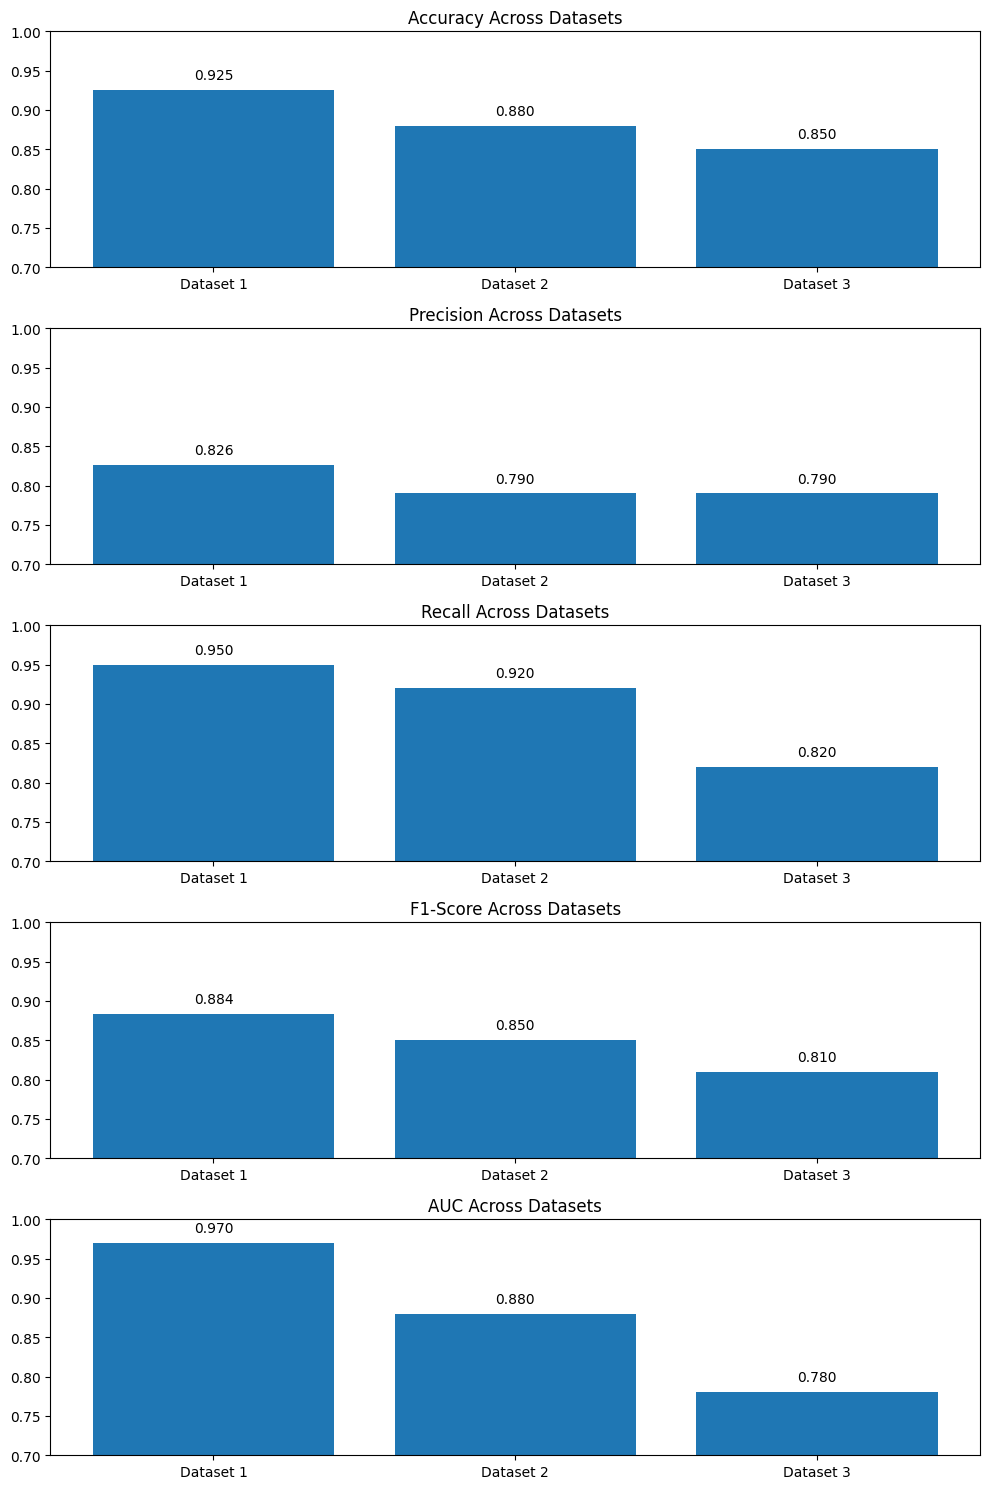

In [ ]:
# Compare model performance across multiple datasets
models = ['Random Forest', 'XGBoost', 'Evidence Theory', 'Stacking Classifier']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

# Create dictionary with performance values from different datasets
# Values from search results [1], [3], and [5]
performance = {
    'Dataset 1': [0.925, 0.826, 0.950, 0.884, 0.97],
    'Dataset 2': [0.88, 0.79, 0.92, 0.85, 0.88],
    'Dataset 3': [0.85, 0.79, 0.82, 0.81, 0.78]
}

# Create grouped bar chart
fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 15))
for i, metric in enumerate(metrics):
    dataset_values = [performance[dataset][i] for dataset in performance.keys()]
    ax = axes[i]
    bars = ax.bar(list(performance.keys()), dataset_values)
    ax.set_title(f'{metric} Across Datasets')
    ax.set_ylim([0.7, 1.0])  # Set y-axis limits

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('dataset_comparison.png', dpi=300)
plt.show()


In [ ]:
def diagnose_model_issues():
    """
    Comprehensive debugging function for student dropout prediction model
    """
    print("🔍 DIAGNOSING MODEL ISSUES...")
    print("=" * 50)

    issues_found = []

    # Check 1: Model Variable Assignment
    try:
        if 'rf_model' in globals():
            print("✅ Model variable (rf_model) exists")
            print(f"   Type: {type(rf_model)}")
        else:
            print("❌ CRITICAL: rf_model variable not found!")
            print("   FIX: Add line: rf_model = train_dropout_model(...)")
            issues_found.append("Missing model assignment")
    except NameError:
        print("❌ CRITICAL: rf_model not defined!")
        issues_found.append("Model not trained")

    # Check 2: Data Shapes
    if 'X_train_enhanced' in globals():
        print(f"✅ Training data shape: {X_train_enhanced.shape}")
        print(f"✅ Feature count: {X_train_enhanced.shape[1]}")

        # Check for anomaly features
        anomaly_cols = [col for col in X_train_enhanced.columns if 'anomaly' in col.lower()]
        if anomaly_cols:
            print(f"✅ Anomaly features found: {len(anomaly_cols)}")
        else:
            print("⚠️  No anomaly features found - may affect performance")
            issues_found.append("Missing anomaly features")
    else:
        print("❌ CRITICAL: Enhanced training data not found!")
        issues_found.append("Data preprocessing incomplete")

    # Check 3: Class Distribution
    if 'y_train' in globals():
        unique, counts = np.unique(y_train, return_counts=True)
        ratio = counts[1] / counts[0] if len(counts) > 1 else 0
        print(f"✅ Class distribution: {dict(zip(unique, counts))}")
        print(f"   Minority/Majority ratio: {ratio:.3f}")

        if ratio < 0.1:
            print("⚠️  Severe class imbalance detected!")
            issues_found.append("Severe class imbalance")

    # Check 4: Model Predictions
    if 'rf_model' in globals() and 'X_test_enhanced' in globals():
        try:
            test_probs = rf_model.predict_proba(X_test_enhanced)[:, 1]
            print(f"✅ Model predictions working")
            print(f"   Prediction range: [{test_probs.min():.3f}, {test_probs.max():.3f}]")
            print(f"   Mean prediction: {test_probs.mean():.3f}")

            # Check for extreme predictions
            if test_probs.std() < 0.01:
                print("⚠️  Very low prediction variance - model may not be learning")
                issues_found.append("Low prediction variance")

            if test_probs.max() < 0.1:
                print("⚠️  All predictions very low - check class weights/SMOTE")
                issues_found.append("Predictions too low")

        except Exception as e:
            print(f"❌ Model prediction error: {str(e)}")
            issues_found.append("Model prediction failure")

    # Check 5: Feature Importance
    if 'rf_model' in globals():
        try:
            importance = rf_model.feature_importances_
            top_features = np.argsort(importance)[-5:][::-1]
            print(f"✅ Feature importance computed")
            print("   Top 5 features:")
            if 'X_train_enhanced' in globals():
                for i, idx in enumerate(top_features):
                    feat_name = X_train_enhanced.columns[idx]
                    print(f"     {i+1}. {feat_name}: {importance[idx]:.4f}")
        except Exception as e:
            print(f"❌ Feature importance error: {str(e)}")

    # Check 6: Threshold Optimization
    if 'optimal_threshold' in globals():
        print(f"✅ Optimal threshold: {optimal_threshold:.3f}")
        if optimal_threshold == 0.5:
            print("⚠️  Using default threshold - consider optimization")
    else:
        print("⚠️  Optimal threshold not found - using default 0.5")
        issues_found.append("No threshold optimization")

    # Summary
    print("\n" + "=" * 50)
    if not issues_found:
        print("🎉 NO CRITICAL ISSUES FOUND!")
        print("   Your model setup looks good.")
    else:
        print(f"⚠️  FOUND {len(issues_found)} ISSUES:")
        for i, issue in enumerate(issues_found, 1):
            print(f"   {i}. {issue}")

    return issues_found

# Quick fix recommendations
def get_quick_fixes():
    """
    Provide quick fixes for common issues
    """
    print("\n🔧 QUICK FIXES:")
    print("=" * 50)

    fixes = {
        "1. Missing Model Assignment": [
            "rf_model = train_dropout_model(X_train_enhanced, y_train, X_val_enhanced, y_val)"
        ],
        "2. Fix Evaluation Function": [
            "Remove duplicate y_proba calculation",
            "Add zero_division=0 to all sklearn metrics"
        ],
        "3. Add Feature Scaling": [
            "scaler = StandardScaler()",
            "X_scaled = scaler.fit_transform(X_train[anomaly_features])",
            "iso_forest.fit(X_scaled)"
        ],
        "4. Fix Class Imbalance": [
            "Reduce class_weight from {0: 1, 1: 20} to {0: 1, 1: 5}",
            "Use sampling_strategy=0.5 instead of 0.6 in SMOTE"
        ],
        "5. Proper Training Order": [
            "1. Train anomaly detector",
            "2. Enhance features",
            "3. Train dropout model (assign to variable!)",
            "4. Optimize threshold",
            "5. Evaluate with optimal threshold"
        ]
    }

    for fix_name, steps in fixes.items():
        print(f"\n{fix_name}:")
        for step in steps:
            print(f"   • {step}")

# Performance debugging
def debug_performance():
    """
    Debug poor model performance
    """
    print("\n📊 PERFORMANCE DEBUGGING:")
    print("=" * 50)

    if 'rf_model' in globals() and 'X_test_enhanced' in globals() and 'y_test' in globals():
        # Get predictions
        y_pred = rf_model.predict(X_test_enhanced)
        y_probs = rf_model.predict_proba(X_test_enhanced)[:, 1]

        # Basic metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"Current Performance:")
        print(f"   Accuracy: {accuracy:.3f}")
        print(f"   Precision: {precision:.3f}")
        print(f"   Recall: {recall:.3f}")
        print(f"   F1-Score: {f1:.3f}")

        # Diagnose issues
        if accuracy < 0.1:
            print("\n❌ CRITICAL: Accuracy < 10% - Model not learning!")
            print("   Likely causes:")
            print("   • Model variable not assigned properly")
            print("   • Wrong features or data preprocessing")
            print("   • Severe class imbalance not handled")

        elif recall < 0.1:
            print("\n⚠️  Very low recall - missing most positive cases")
            print("   Solutions:")
            print("   • Lower prediction threshold")
            print("   • Increase class weights for minority class")
            print("   • Apply SMOTE with higher sampling ratio")

        elif precision < 0.1:
            print("\n⚠️  Very low precision - too many false positives")
            print("   Solutions:")
            print("   • Increase prediction threshold")
            print("   • Improve feature engineering")
            print("   • Reduce class weights for minority class")

    else:
        print("❌ Cannot debug performance - missing required variables")

# Run all diagnostics
print("Running comprehensive model diagnostics...")
diagnose_model_issues()
get_quick_fixes()
debug_performance()

Running comprehensive model diagnostics...
🔍 DIAGNOSING MODEL ISSUES...
✅ Model variable (rf_model) exists
   Type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
✅ Training data shape: (650, 19)
✅ Feature count: 19
✅ Anomaly features found: 4
✅ Class distribution: {np.int64(0): np.int64(456), np.int64(1): np.int64(194)}
   Minority/Majority ratio: 0.425
✅ Model predictions working
   Prediction range: [0.010, 0.730]
   Mean prediction: 0.327
✅ Feature importance computed
   Top 5 features:
     1. prev_gpa: 0.0781
     2. attendance: 0.0762
     3. days_active: 0.0753
     4. meeting_attendance: 0.0744
     5. gpa: 0.0699
✅ Optimal threshold: 0.240

🎉 NO CRITICAL ISSUES FOUND!
   Your model setup looks good.

🔧 QUICK FIXES:

1. Missing Model Assignment:
   • rf_model = train_dropout_model(X_train_enhanced, y_train, X_val_enhanced, y_val)

2. Fix Evaluation Function:
   • Remove duplicate y_proba calculation
   • Add zero_division=0 to all sklearn metrics

3. Add Feature Sca